# 🧹 Purpose of the Script

The purpose of this script is to clean and consolidate the dataset. The goal is to have a single dataframe (persist) that has all the scores.

📚 Datasets Used

We use the following datasets:

1. **MTG zyg-1 strain**: This dataset has a confirmed suppressor for each CVL. This is collected from Dr. Maja Tarailo-Graovac's lab's high-throughput zyg-1 suppressor identification project using C. elegans as a model organism.
2. **Jolanda van Leeuwen's data**: This dataset was curated from published literatures. It has almost 500 unique suppressors but does not have any non-modifier (suppressor).
3. **OLIDA dataset**: This dataset was collected from their website. The plan is to use their data as negative samples.

🛠️ Preprocessing Steps

The preprocessing steps include:

- 🧼 Cleaning each dataset
- ➕ Adding new columns
- 🔄 Consolidating all datasets into one dataframe
- 💾 Saving the dataframe

<small>The git trace of this file can be found in `notebooks/1_add_go_similarity_score.ipynb` file. This file was created on 8 Dec 2023</small>

In [26]:
%reload_kedro

[12/13/23 04:03:55] INFO     Resolved project path as: /project/6013424/rahit/modspy-data.          ]8;id=48245;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=386681;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#139\139]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

                    INFO     Resolved project path as: /project/6013424/rahit/modspy-data.          ]8;id=984209;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=204076;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#139\139]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[12/13/23 04:03:57] INFO     Kedro project ModSpy-Data                                              ]8;id=336962;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=560779;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#108\108]8;;\

                    INFO     Kedro project ModSpy-Data                                              ]8;id=47177;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=604672;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#108\108]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=484952;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=502981;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#109\109]8;;\
                             'pipelines'                                                                           

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=197336;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=765164;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#109\109]8;;\
                             'pipelines'                                                                           

### Import libraries

In [27]:
# -*- coding: utf-8 -*-
# from __future__ import absolute_import, division, print_function, unicode_literals
import random
import logging
import itertools
from rich import print
from IPython.display import display

import pandas as pd
import numpy as np
from modspy_data.helpers import KnowledgeGraphScores

import matplotlib.pyplot as plt
import seaborn as sns

import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, progress, performance_report
from dask_jobqueue import SLURMCluster


import torch
import pronto
import networkx as nx
# from utils import visualize
from nxontology import NXOntology
from nxontology.imports import (from_file, multidigraph_to_digraph,
                                pronto_to_multidigraph)
from networkx.drawing.nx_agraph import graphviz_layout
from nxontology.viz import create_similarity_graphviz
from torch_geometric.data import Data, InMemoryDataset, download_url
import torch_geometric.transforms as T
from torch_geometric.utils.convert import from_networkx
from torch.nn import Linear, ModuleList
from torch_geometric.nn import GATConv, GraphConv
from torch_geometric.loaders import DataLoader, Dataset
from torch_geometric.data import DataLoader
from torch_geometric.utils import convert


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:37                                                                                   │
│                                                                                                  │
│   34 from torch_geometric.utils.convert import from_networkx                                     │
│   35 from torch.nn import Linear, ModuleList                                                     │
│   36 from torch_geometric.nn import GATConv, GraphConv                                           │
│ ❱ 37 from torch_geometric.loaders import DataLoader, Dataset                                     │
│   38 from torch_geometric.data import DataLoader                                                 │
│   39 from torch_geometric.utils import convert                                                   │
│   40                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ModuleNotFoundError: No module named 'torch_geometric.loaders'

### Helper Functions

In [28]:
logging.getLogger().setLevel(logging.WARNING)

In [29]:
# Remove wraping quotation sign ("") from dataframe
def remove_quotes(df):
    df = df.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)
    cols = [c.strip('"') for c in df.columns]
    df.rename(columns=dict(zip(df.columns, cols)), inplace=True)
    return df

In [30]:
# Add info from GO annotations to the JVL data
def match_on_annotation(row, goa, col_name='QueryGene'):
    __goa_filt = goa[goa['DB_Object_Synonym'].str.contains(row[col_name])]
    __annos = __goa_filt['GO_ID'].unique()
    row[f"{col_name}_GO"] = __annos
    return row

In [31]:
# cluster = SLURMCluster(cores=1,
#                        processes=1,
#                        memory="8GB",
#                        account="def-mtarailo_cpu",
#                        walltime="00:05:00")
# client = Client(cluster)
# cluster

### Loading Dataset

##### 📚 Ontologies

In [32]:
# Human GO from UniPort
up_go = catalog.load('go')
up_goa = catalog.load("goa")

# Wormbase GO
wb_go = catalog.load('wb_go')
wb_goa = catalog.load("wb_goa")

# HPO
hpo = catalog.load('hpo')
hpoa = catalog.load('hpoa')

# Wormbase PO
wb_po = catalog.load('wb_po')
wb_poa = catalog.load('wb_poa')

# Alliance Genome Resource Disease Ontology
do = catalog.load('do')
doa = catalog.load('doa')

                    INFO     Loading data from 'go' (KGDataSet)...                              ]8;id=527408;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=440024;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'go' (KGDataSet)...                              ]8;id=942374;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=906582;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

[12/13/23 04:04:20] INFO     Loading data from 'goa' (GAFDataFile)...                           ]8;id=51942;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=285376;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'goa' (GAFDataFile)...                           ]8;id=247041;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=40603;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

[12/13/23 04:04:24] INFO     Loading data from 'wb_go' (KGDataSet)...                           ]8;id=24149;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=501271;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'wb_go' (KGDataSet)...                           ]8;id=111083;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=749836;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

[12/13/23 04:04:42] INFO     Loading data from 'wb_goa' (GAFDataFile)...                        ]8;id=999369;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=232607;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'wb_goa' (GAFDataFile)...                        ]8;id=348349;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=456219;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

[12/13/23 04:04:44] INFO     Loading data from 'hpo' (KGDataSet)...                             ]8;id=752582;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=947587;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'hpo' (KGDataSet)...                             ]8;id=240201;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=969285;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

[12/13/23 04:04:45] WARNING  /project/6013424/rahit/modspy-data/src/modspy_data/extras/datasets/kno ]8;id=370891;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=127439;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             wledge_graph_dataset.py:70: UnicodeWarning: unsound encoding, assuming                
                             utf-8 (75% confidence)                                                                
                               po = pronto.Ontology(handle=load_path)                                              
                                                                                                                   

[12/13/23 04:04:46] INFO     Loading data from 'hpoa' (CSVDataSet)...                           ]8;id=840226;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=484300;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'hpoa' (CSVDataSet)...                           ]8;id=812695;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=753880;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/extras/datas ]8;id=439840;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=147258;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             ets/pandas/csv_dataset.py:160: ParserWarning: Falling back to the                     
                             'python' engine because the 'c' engine does not support regex                         
                             separators (separators > 1 char and different from '\s+' are                          
                             interpreted as regex); you can avoid this warning by specifying                       
                             engine='python'.                                                                      
                               return pd.read_csv(load_path, **self._load_args)                                    
                                                                                                                   

[12/13/23 04:04:48] INFO     Loading data from 'wb_po' (KGDataSet)...                           ]8;id=363032;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=808063;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'wb_po' (KGDataSet)...                           ]8;id=26477;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=850491;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

[12/13/23 04:04:49] INFO     Loading data from 'wb_poa' (GAFDataFile)...                        ]8;id=281481;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=954373;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'wb_poa' (GAFDataFile)...                        ]8;id=739953;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=739619;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

[12/13/23 04:04:52] INFO     Loading data from 'do' (KGDataSet)...                              ]8;id=877228;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=61087;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'do' (KGDataSet)...                              ]8;id=209575;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=604992;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

[12/13/23 04:04:58] INFO     Loading data from 'doa' (CSVDataSet)...                            ]8;id=402436;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=985691;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'doa' (CSVDataSet)...                            ]8;id=203758;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=921341;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/extras/datas ]8;id=437389;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=971845;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             ets/pandas/csv_dataset.py:160: ParserWarning: Falling back to the                     
                             'python' engine because the 'c' engine does not support regex                         
                             separators (separators > 1 char and different from '\s+' are                          
                             interpreted as regex); you can avoid this warning by specifying                       
                             engine='python'.                                                                      
                               return pd.read_csv(load_path, **self._load_args)                                    
                                                                                                                   

In [33]:
# Seperating human and worm Disease ontology annotation
human_doa = doa[doa['Taxon'].str.contains('Taxon:9606')]
worm_doa = doa[doa['Taxon'].str.contains('Taxon:6239')]

In [34]:
# Output some basic information about the graph

# GO
num_nodes = hpo.number_of_nodes()
num_edges = hpo.number_of_edges()
print(num_nodes, num_edges)



30942 41503

MTG related

In [35]:
all_files = [
    # "./data/01_raw/mtgjan_2023_all_combs_scores_2023-01-21.tsv",
     "./data/01_raw/mtg/june_2023_all_combs_scores_2023-05-31.tsv",
    ]
paired_score_df = pd.concat((pd.read_csv(f, sep='\t') for f in all_files))
print(paired_score_df.shape)
paired_score_df

(5374, 56)

,wormbase_gene_id,target_gene_id,go_n_common_ancestors_max,go_n_common_ancestors_avg,go_n_common_ancestors_bma,go_n_union_ancestors_max,go_n_union_ancestors_avg,go_n_union_ancestors_bma,go_batet_max,go_batet_avg,...,wpo_resnik_scaled_bma,wpo_lin_max,wpo_lin_avg,wpo_lin_bma,wpo_jiang_max,wpo_jiang_avg,wpo_jiang_bma,wpo_jiang_seco_max,wpo_jiang_seco_avg,wpo_jiang_seco_bma
0,WBGene00009065,WBGene00006988,14.0,2.310000,4.023256,132.0,31.391667,52.232558,0.368421,0.088865,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,WBGene00021171,WBGene00006988,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,WBGene00003196,WBGene00006988,7.0,1.637131,2.540000,114.0,22.180000,45.340000,1.000000,0.099218,...,0.705974,1.00000,0.334903,0.780028,1.000000,0.123475,0.491183,1.000000,0.310373,0.812368
3,WBGene00011803,WBGene00006988,10.0,2.226054,4.553571,126.0,23.554688,64.589286,1.000000,0.124857,...,0.416211,1.00000,0.414459,0.485633,1.000000,0.147428,0.213067,1.000000,0.442764,0.556453
4,WBGene00011563,WBGene00006988,16.0,3.196970,5.354167,159.0,32.956250,87.000000,1.000000,0.116295,...,0.430959,1.00000,0.343568,0.516151,1.000000,0.138143,0.291885,1.000000,0.371137,0.600209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5369,WBGene00001182,WBGene00006988,8.0,2.379699,4.038462,162.0,31.414583,89.576923,0.444444,0.094707,...,0.693100,1.00000,0.239683,0.773077,1.000000,0.097038,0.419774,1.000000,0.220895,0.796617
5370,WBGene00018280,WBGene00006988,3.0,1.646259,1.851064,112.0,21.500000,39.595745,0.400000,0.091482,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5371,WBGene00018607,WBGene00006988,5.0,1.589286,2.121212,110.0,21.241667,33.325581,0.294118,0.105984,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5372,WBGene00016534,WBGene00006988,3.0,1.653846,1.947368,103.0,17.625000,24.209302,1.000000,0.220233,...,0.375910,0.79501,0.375066,0.389547,0.254411,0.108569,0.113598,0.800823,0.398932,0.412790


In [36]:
df = pd.read_csv("./data/01_raw/mtg/combined_dataset_2022-11-15-07-04.tsv", sep="\t")
df

,index,Sample,chromosome,position,ref,alt,wormbase_gene_id,gene_symbol,gene_start_position,gene_end_position,...,homology,coexpression,coexpression_transferred,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
0,0,MTG93,I,13162538,G,A,WBGene00009065,F22G12.5,13162492,13182725.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,MTG93,II,3797021,T,C,WBGene00021171,Y8A9A.2,3795623,3800608.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,MTG93,II,9362312,G,A,WBGene00003196,mel-11,9358531,9369098.0,...,0.0,74.0,48.0,0.0,101.0,0.0,0.0,0.0,61.0,156.0
3,3,MTG93,III,10045380,C,T,WBGene00011803,T16G12.1,10040191,10049857.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,MTG93,III,10333748,G,A,WBGene00011563,jmjd-4,10332526,10334083.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7849,109,MTG83,X,7912032,G,A,WBGene00016534,C39D10.7,7907955,7913930.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7850,110,MTG83,X,8092257,G,A,WBGene00019493,catp-5,8089826,8098863.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7851,111,MTG83,X,9304661,G,A,WBGene00015177,tmc-2,9303724,9310439.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7852,112,MTG83,X,9435571,G,A,WBGene00006538,tbb-4,9434452,9436893.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
true_mods = pd.read_csv('./data/01_raw/mtg/confirmed_modifiers.tsv', sep="\t")
true_mods.rename(columns={"strain": "Sample", "true_modifier": "gene_symbol"}, inplace=True)

OLIDA related

In [38]:
olida_comb = catalog.load('olida_combinations').pipe(remove_quotes)
# olida_genes = catalog.load('olida_genes') # pd.read_csv('./data/01_raw/olida/Gene.tsv', sep='\t')
olida_gene_comb = catalog.load('olida_gene_combinations').pipe(remove_quotes) #pd.read_csv('./data/01_raw/olida/GeneCombination.tsv', sep='\t')

[12/13/23 04:05:07] INFO     Loading data from 'olida_combinations' (CSVDataSet)...             ]8;id=172198;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=134616;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'olida_combinations' (CSVDataSet)...             ]8;id=178820;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=436909;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/extras/datas ]8;id=807846;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=198152;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             ets/pandas/csv_dataset.py:160: ParserWarning: Falling back to the                     
                             'python' engine because the 'c' engine does not support regex                         
                             separators (separators > 1 char and different from '\s+' are                          
                             interpreted as regex); you can avoid this warning by specifying                       
                             engine='python'.                                                                      
                               return pd.read_csv(load_path, **self._load_args)                                    
                                                                                                                   

                    INFO     Loading data from 'olida_gene_combinations' (CSVDataSet)...        ]8;id=805679;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=668546;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'olida_gene_combinations' (CSVDataSet)...        ]8;id=654205;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=771434;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/extras/datas ]8;id=281998;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=700667;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             ets/pandas/csv_dataset.py:160: ParserWarning: Falling back to the                     
                             'python' engine because the 'c' engine does not support regex                         
                             separators (separators > 1 char and different from '\s+' are                          
                             interpreted as regex); you can avoid this warning by specifying                       
                             engine='python'.                                                                      
                               return pd.read_csv(load_path, **self._load_args)                                    
                                                                                                                   

In [39]:
print(olida_comb.shape)
# print(olida_genes.shape)
print(olida_gene_comb.shape)

(1610, 22)

(1138, 7)

JVL related

In [40]:
jvl = catalog.load('jvl')
print(f"JVL shap: {jvl.shape}")

                    INFO     Loading data from 'jvl' (ExcelDataSet)...                          ]8;id=589996;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=180364;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'jvl' (ExcelDataSet)...                          ]8;id=404628;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=969874;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

JVL shap: (932, 18)

## 🔍 Adding Ontology Annotation to each Dataset
In this step, we're conducting a thorough examination of our data sources. Our goal is to ensure standardization across all sources, which will facilitate smoother processing down the line. Standardization here means that the data is clean, consistent, and in a format that our later processes can easily handle. 

Ideally, each dataset should have at least two columns (target and modifier) containing gene symbols. These gene symbols are crucial as they serve as unique identifiers for our genetic data. Having these in each dataset ensures we can accurately cross-reference and analyze our data across multiple sources. 🧬🔬

### 📚 Ontologies

In [41]:
def add_annotation(df: pd.DataFrame, src_trgt_cols: list, term_id_map: dict):
    # Adding a new column to df for Ontology IDs associated with each gene in source_col
    for source, target in src_trgt_cols:
        df[target] = df[source].map(term_id_map)
        df[target+'_count'] = df[target].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
    return df

In [42]:
# Creating mappin of genes to their associated ontology term IDs
onto_to_gene_map = {
    'human': {
        'GO': up_goa.groupby('DB_Object_Symbol')['GO_ID'].apply(lambda x: ','.join(x)).to_dict(),
        'PO': hpoa.groupby('gene_symbol')['hpo_id'].apply(lambda x: ','.join(x)).to_dict(),
        'DO': human_doa.groupby('DBObjectSymbol')['DOID'].apply(lambda x: ','.join(x)).to_dict(),
    },
    'celegans': {
        'GO': wb_goa.groupby('DB_Object_Symbol')['GO_ID'].apply(lambda x: ','.join(x)).to_dict(),
        'PO': wb_poa.groupby('DB_Object_Symbol')['GO_ID'].apply(lambda x: ','.join(x)).to_dict(),
        'DO': worm_doa.groupby('DBObjectSymbol')['DOID'].apply(lambda x: ','.join(x)).to_dict(),
    }
}

In [43]:

src_trgt_cols = {
    'MTG': [
        [('target_gene_symbol', 'target_GOs'), ('gene_symbol', 'modifier_GOs')],
        [('target_gene_symbol', 'target_POs'), ('gene_symbol', 'modifier_POs')],
        [('target_gene_symbol', 'target_DOs'), ('gene_symbol', 'modifier_DOs')],
    ],
    'OLIDA': [
        [('gene_a', 'target_GOs'), ('gene_b', 'modifier_GOs')],
        [('gene_a', 'target_POs'), ('gene_b', 'modifier_POs')],
        [('gene_a', 'target_DOs'), ('gene_b', 'modifier_DOs')],
    ],
    'JVL': [
        [('QueryGene', 'target_GOs'), ('SuppressorGene', 'modifier_GOs')],
        [('QueryGene', 'target_POs'), ('SuppressorGene', 'modifier_POs')],
        [('QueryGene', 'target_DOs'), ('SuppressorGene', 'modifier_DOs')],
    ],
}

##### 1️⃣ MTG

In [44]:
# Setting modifier value to int 1
true_mods['is_modifier'] = 1

In [45]:
# Merge dataframes (to use already calculated similarity values and consistency)
print(f"Old dataframe shape: {df.shape}")
paired_df = df.merge(paired_score_df, how='left', on=['wormbase_gene_id','target_gene_id'])
print(f"New dataframe shape: {paired_df.shape}")

Old dataframe shape: (7854, 102)

New dataframe shape: (7854, 156)

In [46]:
# now merging data table containing true modifiers
m_df = pd.merge(paired_df, true_mods, how='left', on=['Sample', 'gene_symbol']).drop('index', axis=1).fillna(0)
confirmed_samples = m_df[m_df['is_modifier']==True]['Sample'].unique()
m_df = m_df[m_df['Sample'].isin(confirmed_samples)]
m_df.head()

,Sample,chromosome,position,ref,alt,wormbase_gene_id,gene_symbol,gene_start_position,gene_end_position,strain,...,wpo_lin_max,wpo_lin_avg,wpo_lin_bma,wpo_jiang_max,wpo_jiang_avg,wpo_jiang_bma,wpo_jiang_seco_max,wpo_jiang_seco_avg,wpo_jiang_seco_bma,is_modifier
0,MTG93,I,13162538,G,A,WBGene00009065,F22G12.5,13162492,13182725.0,93,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,MTG93,II,3797021,T,C,WBGene00021171,Y8A9A.2,3795623,3800608.0,93,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,MTG93,II,9362312,G,A,WBGene00003196,mel-11,9358531,9369098.0,93,...,1.0,0.334903,0.780028,1.0,0.123475,0.491183,1.0,0.310373,0.812368,0.0
3,MTG93,III,10045380,C,T,WBGene00011803,T16G12.1,10040191,10049857.0,93,...,1.0,0.414459,0.485633,1.0,0.147428,0.213067,1.0,0.442764,0.556453,0.0
4,MTG93,III,10333748,G,A,WBGene00011563,jmjd-4,10332526,10334083.0,93,...,1.0,0.343568,0.516151,1.0,0.138143,0.291885,1.0,0.371137,0.600209,0.0


In [47]:
print(f"# of Samples: {len(m_df['Sample'].unique())}")
print(f"# of Unique Genes: {len(m_df['wormbase_gene_id'].unique())}")
print(f"# of Variants: {m_df.shape[0]}")
print(f"# of columns: {len(m_df.columns)}")

# of Samples: 71

# of Unique Genes: 5182

# of Variants: 7330

# of columns: 156

In [48]:
print(f"Last column: {m_df.columns[-1]}")

Last column: is_modifier

In [49]:
list(m_df.columns)

['Sample',
 'chromosome',
 'position',
 'ref',
 'alt',
 'wormbase_gene_id',
 'gene_symbol',
 'gene_start_position',
 'gene_end_position',
 'strain',
 'variant_id',
 'target_gene_id',
 'target_gene_symbol',
 'go_Resnik_max_similarity',
 'go_Resnik_BMA_similarity',
 'go_Resnik_avg_similarity',
 'go_Lin_max_similarity',
 'go_Lin_BMA_similarity',
 'go_Lin_avg_similarity',
 'go_Jiang-Conrath_max_similarity',
 'go_Jiang-Conrath_BMA_similarity',
 'go_Jiang-Conrath_avg_similarity',
 'go_SimRel_max_similarity',
 'go_SimRel_BMA_similarity',
 'go_SimRel_avg_similarity',
 'go_SimIC_max_similarity',
 'go_SimIC_BMA_similarity',
 'go_SimIC_avg_similarity',
 'go_G-SESAME_max_similarity',
 'go_G-SESAME_BMA_similarity',
 'go_G-SESAME_avg_similarity',
 'go_SimICND_max_similarity',
 'go_SimICND_BMA_similarity',
 'go_SimICND_avg_similarity',
 'go_SimICNP_max_similarity',
 'go_SimICNP_BMA_similarity',
 'go_SimICNP_avg_similarity',
 'wpo_Resnik_max_similarity',
 'wpo_Resnik_BMA_similarity',
 'wpo_Resnik_avg_

🏷️ Adding Ontology Annotation - MTG

In [50]:
i = 0
for onto, map in onto_to_gene_map['celegans'].items():
    # for each type of ontologies
    # we add annotation for soure and target gene
    m_df = add_annotation(m_df, src_trgt_cols['MTG'][i], map)
    i += 1

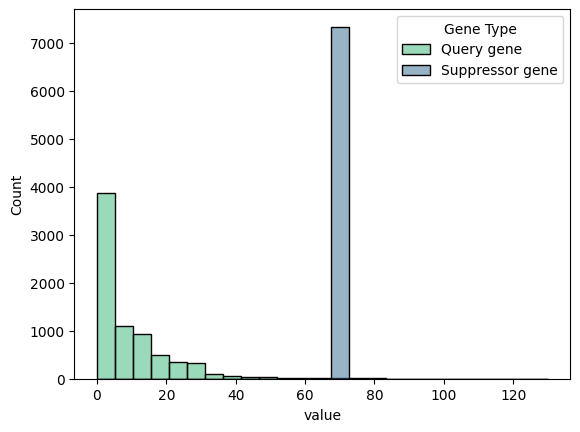

In [51]:
# Plotting annotation count
melted_df = pd.melt(m_df, value_vars=['target_GOs_count', 'modifier_GOs_count'])

sns.histplot(data=melted_df, x='value', hue='variable', kde=False, palette='viridis')
plt.legend(title='Gene Type', labels=['Query gene', 'Suppressor gene'])
plt.show()

In [76]:
# catalog.save('zyg1_annotated', m_df)

[12/13/23 04:20:42] INFO     Saving data to 'zyg1_annotated' (CSVDataSet)...                    ]8;id=521685;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=29902;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#531\531]8;;\

                    INFO     Saving data to 'zyg1_annotated' (CSVDataSet)...                    ]8;id=871371;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=989857;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#531\531]8;;\

####  2️⃣ OLIDA

In [53]:
olida_comb_filtered = olida_comb[olida_comb['Oligogenic Effect'] != 'Unknown']
print(olida_comb_filtered.shape)
print(olida_comb_filtered['Oligogenic Effect'].value_counts())

(173, 22)

Monogenic+Modifier          85
True Digenic                70
Dual Molecular Diagnosis    18
Name: Oligogenic Effect, dtype: int64

In [54]:
olida_comb_filtered.columns

Index(['OLIDA ID', 'Omim Id', 'Diseases', 'Oligogenic Effect', 'Ethnicity',
       'References', 'Associated Variants', 'FAMmanual', 'STATmanual',
       'STATknowledge', 'STATmeta', 'GENEmanual', 'GENEmanual harmonized',
       'GENEknowledge', 'GENEmeta', 'VARmanual', 'VARknowledge', 'VARmeta',
       'FUNmanual', 'FUNmeta', 'FINALmanual', 'FINALmeta'],
      dtype='object')

In [55]:
# Splitting and expanding on synonymous gene symbols
olida_gene_comb['olida_id'] = olida_gene_comb['Oligogenic variant combinations'].str.split(';')
olida_gene_comb = olida_gene_comb.explode('olida_id')

In [56]:
# Adding OLIDA combination information
_olida_m = olida_gene_comb.merge(olida_comb_filtered, how='left', left_on='olida_id', right_on='OLIDA ID')
print(_olida_m.shape)
olida_merged = _olida_m.dropna(subset=['OLIDA ID']).reindex()

(1610, 30)

In [57]:
olida_merged.shape

(111, 30)

In [58]:
print(olida_merged.shape)
print(olida_merged['Oligogenic Effect'].value_counts())

(111, 30)

Monogenic+Modifier          50
True Digenic                43
Dual Molecular Diagnosis    18
Name: Oligogenic Effect, dtype: int64

In [59]:
# Splitting gene symbols and keeping as a list
olida_merged['gene_list'] = olida_merged['Genes'].str.split(';')
olida_merged['gene_list_len'] = olida_merged.apply(lambda row: len(row['gene_list']), axis=1)
print(olida_merged['gene_list_len'].value_counts())

2    96
3    15
Name: gene_list_len, dtype: int64

In [60]:
# Generate unique pairs from the gene list
olida_merged['gene_pairs'] = olida_merged.apply(lambda r: list(itertools.combinations(r['gene_list'], 2)), axis=1)
olida_pairs = olida_merged.explode('gene_pairs')
print(olida_pairs.shape)

(141, 33)

In [61]:
# Splitting the gene_pairs into two columns
# olida_pairs[['gene_a', 'gene_b']] = olida_pairs['gene_pairs'].map(pd.Series)
olida_pairs[['gene_a', 'gene_b']] = olida_pairs['gene_pairs'].apply(pd.Series)
olida_pairs['gene_a'] = olida_pairs['gene_a'].map(lambda x: x.strip())
olida_pairs['gene_b'] = olida_pairs['gene_b'].map(lambda x: x.strip())

print(olida_pairs['gene_a'].value_counts())
print(olida_pairs['gene_b'].value_counts())


CHD7      6
FGFR1     5
MYO7A     4
GJB2      3
CYP7A1    3
         ..
EDA       1
LMBRD1    1
NKX2-5    1
CARD9     1
FOXC2     1
Name: gene_a, Length: 106, dtype: int64

USH2A     4
PROKR2    3
LRP6      3
MYH7      3
OPTN      2
         ..
WNT10A    1
MTR       1
ZIC3      1
MYD88     1
PIEZO1    1
Name: gene_b, Length: 114, dtype: int64

🏷️ Adding Ontology Annotation - OLIDA

In [62]:
i = 0
for onto, map in onto_to_gene_map['human'].items():
    # for each type of ontologies
    # we add annotation for soure and target gene
    olida_pairs = add_annotation(olida_pairs, src_trgt_cols['OLIDA'][i], map)
    i += 1

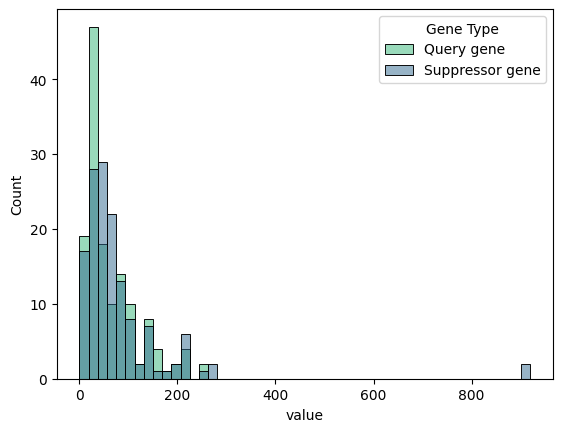

In [63]:
# Plotting annotation count
melted_df = pd.melt(olida_pairs, value_vars=['target_GOs_count', 'modifier_GOs_count'])

sns.histplot(data=melted_df, x='value', hue='variable', kde=False, palette='viridis')
plt.legend(title='Gene Type', labels=['Query gene', 'Suppressor gene'])
plt.show()

In [65]:
olida_pairs.head(3)

,Entry Id,Genes,Genes Relationship,Protein Interactions,Common Pathways,GENEmeta_x,Oligogenic variant combinations,olida_id,OLIDA ID,Omim Id,...,modifier_GOs,modifier_GOs_count,target_POs,target_POs_count,modifier_POs,modifier_POs_count,target_DOs,target_DOs_count,modifier_DOs,modifier_DOs_count
0,1,ALAD; CPO,Involved in the same disease;Same pathway;Rele...,N.A.,N.A.,2,OLI001,OLI001,OLI001,121300,...,"GO:0004181,GO:0008270,GO:0005886,GO:0016324,GO...",8,"HP:0001271,HP:0001289,HP:0001256,HP:0001252,HP...",54,NaN,0,"DOID:5082,DOID:10923,DOID:3132,DOID:3132,DOID:...",12,NaN,0
6,6,ADD3; KAT2B,Affecting the same tissue;Relevant pathways fo...,N.A.,N.A.,3,OLI007,OLI007,OLI007,600995; 607832; 616893; 618179; 615573; 256370...,...,"GO:0000977,GO:0003682,GO:0003712,GO:0003712,GO...",167,"HP:0007256,HP:0001250,HP:0001264,HP:0001260,HP...",20,NaN,0,"DOID:0081361,DOID:1969,DOID:576,DOID:10763,DOI...",6,"DOID:7148,DOID:684,DOID:3748,DOID:1612,DOID:55...",6
7,7,SLC34A1; SLC34A3,Involved in the same disease;Affecting the sam...,N.A.,Sodium-coupled phosphate cotransporters;Transp...,3,OLI008,OLI008,OLI008,241530,...,"GO:0005436,GO:0005436,GO:0005436,GO:0005515,GO...",21,"HP:0003774,HP:0001252,HP:0002515,HP:0000083,HP...",87,"HP:0001252,HP:0002515,HP:0002663,HP:0001324,HP...",60,"DOID:7998,DOID:784,DOID:0050336,DOID:1459,DOID...",14,DOID:0050947,1


In [79]:
# catalog.save('olida_annotated', olida_pairs)

[12/13/23 04:23:02] INFO     Saving data to 'olida_annotated' (CSVDataSet)...                   ]8;id=712237;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=872750;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#531\531]8;;\

                    INFO     Saving data to 'olida_annotated' (CSVDataSet)...                   ]8;id=215568;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=758033;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#531\531]8;;\

#### 3️⃣ Jolanda van Leewen

In [67]:
jvl_pairs = jvl[['QueryGene', 'SuppressorGene']]
print(jvl_pairs['QueryGene'].value_counts())
print(jvl_pairs['SuppressorGene'].value_counts())

HBB       412
CFTR      144
SMN1       44
BRCA1      37
HTT        27
         ... 
LUC7L3      1
MFAP1       1
MITF        1
MUS81       1
XPA         1
Name: QueryGene, Length: 93, dtype: int64

HBA2       96
BCL11A     79
MYB        62
HBG2       53
SMN2       43
           ..
PRKD2       1
PPP2R2B     1
PPP2R1A     1
PLXNA1      1
MUTYH       1
Name: SuppressorGene, Length: 417, dtype: int64

🏷️ Adding Ontology Annotation - JVL

In [68]:
i = 0
for onto, map in onto_to_gene_map['human'].items():
    # for each type of ontologies
    # we add annotation for soure and target gene
    jvl = add_annotation(jvl, src_trgt_cols['JVL'][i], map)
    i += 1

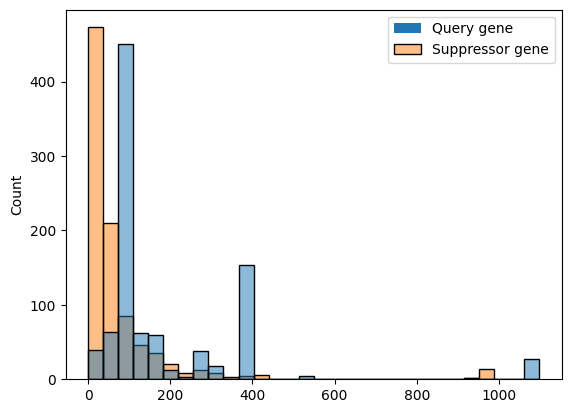

In [69]:
# Assuming df is your DataFrame and 'column' is the column you want to plot
sns.histplot(jvl[['target_GOs_count', 'modifier_GOs_count']], kde=False, bins=30)
plt.legend(labels=['Query gene', 'Suppressor gene'])
plt.show()

In [70]:
jvl.head(3)

,PubmedID,Category,Tissue,QueryGene,QueryFunction,QueryMutation,QueryType,SuppressorGene,SuppressorFunction,SuppressorMutation,...,modifier_GOs,modifier_GOs_count,target_POs,target_POs_count,modifier_POs,modifier_POs_count,target_DOs,target_DOs_count,modifier_DOs,modifier_DOs_count
0,27358062,Patients,Neuron,APOE,Lipid and sterol biosynthesis & transport,C112R/C112R,-,CASP7,Signaling & stress response,L133*/?,...,"GO:0003723,GO:0004190,GO:0004197,GO:0004197,GO...",92,"HP:0001114,HP:0010874,HP:0002423,HP:0100820,HP...",99,NaN,0,"DOID:9970,DOID:10652,DOID:14330,DOID:9744,DOID...",85,"DOID:10652,DOID:7148,DOID:219,DOID:1612,DOID:1...",12
1,24116184,Patients,-,APOE,Lipid and sterol biosynthesis & transport,C112R/?,-,HBB,Metabolism & mitochondria,E6V/+,...,"GO:0004601,GO:0031720,GO:0005344,GO:0005344,GO...",89,"HP:0001114,HP:0010874,HP:0002423,HP:0100820,HP...",99,"HP:0010885,HP:0032231,HP:0001297,HP:0002597,HP...",262,"DOID:9970,DOID:10652,DOID:14330,DOID:9744,DOID...",85,"DOID:14330,DOID:12241,DOID:12241,DOID:12241,DO...",23
2,30867273,Patients,Neuron,APOE,Lipid and sterol biosynthesis & transport,C112R/?,-,KL,NaN,"F352V,C370S/+",...,"GO:0004566,GO:0004566,GO:0005179,GO:0005499,GO...",85,"HP:0001114,HP:0010874,HP:0002423,HP:0100820,HP...",99,"HP:0006051,HP:0002514,HP:0000007,HP:0025441,HP...",16,"DOID:9970,DOID:10652,DOID:14330,DOID:9744,DOID...",85,"DOID:784,DOID:783,DOID:557,DOID:557,DOID:10763...",19


In [80]:
# catalog.save('jvl_annotated', jvl)

[12/13/23 04:23:46] INFO     Saving data to 'jvl_annotated' (CSVDataSet)...                     ]8;id=145919;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=653930;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#531\531]8;;\

                    INFO     Saving data to 'jvl_annotated' (CSVDataSet)...                     ]8;id=467345;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=35946;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#531\531]8;;\

# Combine Datasets

Comparing OLIDA pairs with JVL

In [44]:
print(olida_pairs['Oligogenic Effect'].value_counts())

Monogenic+Modifier          66
True Digenic                47
Dual Molecular Diagnosis    28
Name: Oligogenic Effect, dtype: int64

In [45]:
# # All type of pairs
# jvl_match = jvl.merge(olida_pairs[olida_pairs['gene_list_len']==2], how='inner', left_on='SuppressorGene', right_on='gene_a')
# print(jvl_match[['QueryGene', 'SuppressorGene','gene_a', 'gene_b']])

# jvl_match = jvl.merge(olida_pairs[olida_pairs['gene_list_len']==2], how='inner', left_on='QueryGene', right_on='gene_a')
# print(jvl_match[['QueryGene', 'SuppressorGene','gene_a', 'gene_b']])


# jvl_match = jvl.merge(olida_pairs[olida_pairs['gene_list_len']==2], how='inner', left_on='SuppressorGene', right_on='gene_b')
# print(jvl_match[['QueryGene', 'SuppressorGene','gene_a', 'gene_b']])

# jvl_match = jvl.merge(olida_pairs[olida_pairs['gene_list_len']==2], how='inner', left_on='QueryGene', right_on='gene_b')
# print(jvl_match[['QueryGene', 'SuppressorGene','gene_a', 'gene_b']])

In [46]:
# # Considering ONLY Digenic or Dual Molecular effects FOR COMPARISON.
# ########################################################################################
# op_filt = olida_pairs[olida_pairs['Oligogenic Effect']!='Monogenic+Modifier']
# print(op_filt.shape)
# ######################################################################################

# jvl_match = jvl.merge(op_filt[op_filt['gene_list_len']==2], how='inner', left_on='SuppressorGene', right_on='gene_a')
# print(jvl_match[['QueryGene', 'SuppressorGene','gene_a', 'gene_b']])

# jvl_match = jvl.merge(op_filt[op_filt['gene_list_len']==2], how='inner', left_on='QueryGene', right_on='gene_a')
# print(jvl_match[['QueryGene', 'SuppressorGene','gene_a', 'gene_b']])


# jvl_match = jvl.merge(op_filt[op_filt['gene_list_len']==2], how='inner', left_on='SuppressorGene', right_on='gene_b')
# print(jvl_match[['QueryGene', 'SuppressorGene','gene_a', 'gene_b']])

# jvl_match = jvl.merge(op_filt[op_filt['gene_list_len']==2], how='inner', left_on='QueryGene', right_on='gene_b')
# print(jvl_match[['QueryGene', 'SuppressorGene','gene_a', 'gene_b']])

In [47]:
olida_pairs.columns

Index(['Entry Id', 'Genes', 'Genes Relationship', 'Protein Interactions',
       'Common Pathways', 'GENEmeta_x', 'Oligogenic variant combinations',
       'olida_id', 'OLIDA ID', 'Omim Id', 'Diseases', 'Oligogenic Effect',
       'Ethnicity', 'References', 'Associated Variants', 'FAMmanual',
       'STATmanual', 'STATknowledge', 'STATmeta', 'GENEmanual',
       'GENEmanual harmonized', 'GENEknowledge', 'GENEmeta_y', 'VARmanual',
       'VARknowledge', 'VARmeta', 'FUNmanual', 'FUNmeta', 'FINALmanual',
       'FINALmeta', 'gene_list', 'gene_list_len', 'gene_pairs', 'gene_a',
       'gene_b', 'target_GOs', 'target_GOs_count', 'modifier_GOs',
       'modifier_GOs_count', 'target_POs', 'target_POs_count', 'modifier_POs',
       'modifier_POs_count', 'target_DOs', 'target_DOs_count', 'modifier_DOs',
       'modifier_DOs_count'],
      dtype='object')

In [48]:
# Taking ONLY Digenic or Dual Molecular effects. Because we don't know the direction of 
# effect for Monogenic+Modifier pairs
olida_pairs = olida_pairs[olida_pairs['Oligogenic Effect']!='Monogenic+Modifier']
print(olida_pairs['Oligogenic Effect'].value_counts())
print(olida_pairs.shape)

True Digenic                47
Dual Molecular Diagnosis    28
Name: Oligogenic Effect, dtype: int64

(75, 47)

In [49]:
# Adding source column
jvl['source'] = 'JVL'
olida_pairs['source'] = 'OLIDA'
m_df['source'] = 'MTG'

# Classification labels
jvl['is_modifier'] = 1
olida_pairs['is_modifier'] = 0

# Rename columns to indicate same information
jvl.rename(columns={'QueryGene': 'target_gene', 'SuppressorGene': 'modifier_gene'}, inplace=True)
olida_pairs.rename(columns={'gene_a': 'target_gene', 'gene_b': 'modifier_gene'}, inplace=True)
m_df.rename(columns={'gene_symbol': 'modifier_gene', 'target_gene_symbol': 'target_gene'}, inplace=True)


[12/11/23 13:46:09] WARNING  /tmp/ipykernel_25153/2853934392.py:3: SettingWithCopyWarning:          ]8;id=155581;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=595693;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               olida_pairs['source'] = 'OLIDA'                                                     
                                                                                                                   

                    WARNING  /tmp/ipykernel_25153/2853934392.py:8: SettingWithCopyWarning:          ]8;id=157113;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=269117;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               olida_pairs['is_modifier'] = 0                                                      
                                                                                                                   

                    WARNING  /tmp/ipykernel_25153/2853934392.py:12: SettingWithCopyWarning:         ]8;id=612444;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=5824;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               olida_pairs.rename(columns={'gene_a': 'target_gene', 'gene_b':                      
                             'modifier_gene'}, inplace=True)                                                       
                                                                                                                   

## Consolidating 3 datasets

In [50]:
dataset_df = pd.concat([jvl, olida_pairs, m_df])
print(dataset_df.shape)
print(dataset_df['source'].value_counts())

(8337, 218)

MTG      7330
JVL       932
OLIDA      75
Name: source, dtype: int64

In [51]:
# Reordering important columns
desired_first_columns = ['source', 'target_gene', 'modifier_gene', 'is_modifier'] 
remaining_columns = [col for col in dataset_df.columns if col not in desired_first_columns]
new_column_order = desired_first_columns + remaining_columns
dataset_df = dataset_df[new_column_order]
dataset_df.head()


,source,target_gene,modifier_gene,is_modifier,PubmedID,Category,Tissue,QueryFunction,QueryMutation,QueryType,...,wpo_resnik_scaled_bma,wpo_lin_max,wpo_lin_avg,wpo_lin_bma,wpo_jiang_max,wpo_jiang_avg,wpo_jiang_bma,wpo_jiang_seco_max,wpo_jiang_seco_avg,wpo_jiang_seco_bma
0,JVL,APOE,CASP7,1.0,27358062.0,Patients,Neuron,Lipid and sterol biosynthesis & transport,C112R/C112R,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,JVL,APOE,HBB,1.0,24116184.0,Patients,-,Lipid and sterol biosynthesis & transport,C112R/?,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JVL,APOE,KL,1.0,30867273.0,Patients,Neuron,Lipid and sterol biosynthesis & transport,C112R/?,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,JVL,APOE,KL,1.0,32282020.0,Patients,Neuron,Lipid and sterol biosynthesis & transport,C112R/?,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,JVL,ATR,ETV1,1.0,23284306.0,Cells,-,DNA replication and repair;Signaling & stress ...,silencing/silencing,LOF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# # TODO check gene info to retrieve gene ID for better comparison of uniqueness
dataset_df.to_csv('./data/02_intermediate/v4/20231210-combined-uncleaned-uncalc.tsv', index=False, sep='\t')

In [53]:
dataset_df.drop_duplicates(subset=['target_gene', 'modifier_gene'], inplace=True)

In [54]:
# dataset_df.sample(100)[['target_gene', 'modifier_gene', 'target_POs', 'modifier_POs']].to_csv('./data/02_intermediate/v4/combined-sampled-sm.tsv', index=False, sep='\t')

In [55]:
print(dataset_df['source'].value_counts())
print(dataset_df.shape)

MTG      5182
JVL       476
OLIDA      74
Name: source, dtype: int64

(5732, 218)

In [107]:
# vars(up_go.node_info('GO:0000082').nxo)
# for node in list(up_go.graph.nodes.data())[None:2:None]:
#     print(node)
print(up_go.freeze())
f_hum_go = up_go.freeze()
print(f_hum_go)
# nxo_info = ['n_common_ancestors', 'n_union_ancestors', 'batet', 'batet_log', 'resnik', 'resnik_scaled', 'lin', 'jiang', 'jiang_seco']
    

None

None

In [63]:
nodes = up_go.graph.nodes
for n in list(nodes)[:5]:
    print(up_goa[up_goa['GO_ID']==n])

Empty DataFrame
Columns: [DB, DB_Object_ID, DB_Object_Symbol, Qualifier, GO_ID, DB_Reference, Evidence_Code, With_Or_From, Aspect, 
DB_Object_Name, DB_Object_Synonym, DB_Object_Type, Taxon, Date, Assigned_By, Annotation_Extension]
Index: []

DB DB_Object_ID DB_Object_Symbol    Qualifier       GO_ID  \
38753   UniProtKB       O60313             OPA1  involved_in  GO:0000002   
122794  UniProtKB       P12235          SLC25A4  involved_in  GO:0000002   
145340  UniProtKB       P19971             TYMP  involved_in  GO:0000002   
185939  UniProtKB       P36776            LONP1  involved_in  GO:0000002   
189852  UniProtKB       P39210            MPV17  involved_in  GO:0000002   
267197  UniProtKB       Q02078            MEF2A  involved_in  GO:0000002   
436956  UniProtKB       Q96CQ1         SLC25A36  involved_in  GO:0000002   
468496  UniProtKB       Q9BQP7            MGME1  involved_in  GO:0000002   
470860  UniProtKB       Q9BSK2         SLC25A33  involved_in  GO:0000002   
496905  UniProtKB       Q9H611             PIF1  involved_in  GO:0000002   
553619  UniProtKB       Q9Y243             AKT3  involved_in  GO:0000002   
570683  UniProtKB       Q9BSK2         SLC25A33  involved_in  GO:0000002   
576639  UniProtKB       Q96CQ1         SLC25A36  involved_in  GO:0000002   

          DB_Reference Evidence_Code  \
38753    PMID:18158317           IMP   
122794   PMID:10926541           TAS   
145340    PMID:9924029           IMP   
185939   PMID:17420247           NAS   
189852   PMID:16582910           IMP   
267197  GO_REF:0000024           ISS   
436956   PMID:25320081           IDA   
468496   PMID:23313956           IMP   
470860   PMID:25320081           IDA   
496905  GO_REF:0000104           IEA   
553619   PMID:18524868           IMP   
570683   PMID:21873635           IBA   
576639   PMID:21873635           IBA   

                                             With_Or_From Aspect  \
38753                                                          P   
122794                                                         P   
145340                                                         P   
185939                                                         P   
189852                                                         P   
267197                                   UniProtKB:Q60929      P   
436956                                                         P   
468496                                                         P   
470860                                                         P   
496905                                UniRule:UR000112749      P   
553619                                                         P   
570683  PANTHER:PTN000642030|SGD:S000000396|UniProtKB:...      P   
576639  PANTHER:PTN000642030|SGD:S000000396|UniProtKB:...      P   

                                        DB_Object_Name    DB_Object_Synonym  \
38753      Dynamin-like 120 kDa protein, mitochondrial        OPA1|KIAA0567   
122794                           ADP/ATP translocase 1    SLC25A4|AAC1|ANT1   
145340                         Thymidine phosphorylase           TYMP|ECGF1   
185939             Lon protease homolog, mitochondrial         LONP1|PRSS15   
189852                                   Protein Mpv17                MPV17   
267197             Myocyte-specific enhancer factor 2A           MEF2A|MEF2   
436956              Solute carrier family 25 member 36             SLC25A36   
468496  Mitochondrial genome maintenance exonuclease 1  MGME1|C20orf72|DDK1   
470860              Solute carrier family 25 member 33             SLC25A33   
496905                 ATP-dependent DNA helicase PIF1        PIF1|C15orf20   
553619       RAC-gamma serine/threonine-protein kinase            AKT3|PKBG   
570683              Solute carrier family 25 member 33             SLC25A33   
576639              Solute carrier family 25 member 36             SLC25A36   

       DB_Object_Type       Taxon      Date Assigned_By Annotation_Extension  
38753         protein  taxon:9606  20141125     UniProt                 None  
122794        protein  taxon:9606  20030904        PINC                 None  
145340        protein  taxon:9606  20160722        CAFA                 None  
185939       

DB DB_Object_ID DB_Object_Symbol    Qualifier       GO_ID  \
52828   UniProtKB       O75900           MMP23B  involved_in  GO:0000003   
570863  UniProtKB       Q5TKA1             LIN9  involved_in  GO:0000003   
623757  UniProtKB       O43555            GNRH2  involved_in  GO:0000003   
625982  UniProtKB       P01148            GNRH1  involved_in  GO:0000003   

         DB_Reference Evidence_Code  \
52828    PMID:9988691           IEP   
570863  PMID:21873635           IBA   
623757  PMID:21873635           IBA   
625982  PMID:21873635           IBA   

                                             With_Or_From Aspect  \
52828                                                          P   
570863  PANTHER:PTN000495591|FB:FBgn0004372|WB:WBGene0...      P   
623757  PANTHER:PTN000829165|UniProtKB:P37042|ZFIN:ZDB...      P   
625982  PANTHER:PTN000829165|UniProtKB:P37042|ZFIN:ZDB...      P   

                     DB_Object_Name    DB_Object_Synonym DB_Object_Type  \
52828   Matrix metalloproteinase-23   MMP23B|MMP21|MMP22        protein   
570863        Protein lin-9 homolog        LIN9|BARA|TGS        protein   
623757           Progonadoliberin-2                GNRH2        protein   
625982           Progonadoliberin-1  GNRH1|GNRH|GRH|LHRH        protein   

             Taxon      Date Assigned_By Annotation_Extension  
52828   taxon:9606  20061107     UniProt                 None  
570863  taxon:9606  20200808  GO_Central                 None  
623757  taxon:9606  20220922  GO_Central                 None  
625982  taxon:9606  20220922  GO_Central                 None

Empty DataFrame
Columns: [DB, DB_Object_ID, DB_Object_Symbol, Qualifier, GO_ID, DB_Reference, Evidence_Code, With_Or_From, Aspect, 
DB_Object_Name, DB_Object_Synonym, DB_Object_Type, Taxon, Date, Assigned_By, Annotation_Extension]
Index: []

Empty DataFrame
Columns: [DB, DB_Object_ID, DB_Object_Symbol, Qualifier, GO_ID, DB_Reference, Evidence_Code, With_Or_From, Aspect, 
DB_Object_Name, DB_Object_Synonym, DB_Object_Type, Taxon, Date, Assigned_By, Annotation_Extension]
Index: []

\#TODO Create unified ontology

- Use interaction to 'connect' the different ontology networks. A node can be used to indicate interaction. For example, if we have a node called 'interaction' and we connect it to 'GO:0000001' and 'PO:0000001', then we can say that 'GO:0000001' and 'PO:0000001' are connected. This will allow us to use the same ontology network for all 3 datasets.

In [57]:
#int_ddf = catalog.load('string_interactions')

In [58]:
#display(int_ddf.head(5).compute())

In [ ]:
up_go

: 

In [57]:
def get_subgraph(phenotype_list: list, graph):
    # Remove any potential empty strings and duplicates
    phenotype_list = list(filter(None, set(phenotype_list)))
    # Filter nodes that are in the graph
    nodes = [node for node in phenotype_list if node in graph.nodes]
    return graph.subgraph(nodes).copy()

def terms_to_nx_subgraph(terms: str, g):
    if type(terms) is str:
        return get_subgraph(terms.split(','), g)
    else:
        return None

# Parse the 'target_*Os' and 'modifier_*Os' columns and create subgraphs
#########################################################################
dataset_df['target_GOs_subgraph'] = dataset_df['target_GOs'].apply(terms_to_nx_subgraph, g=up_go.graph)
dataset_df['modifier_GOs_subgraph'] = dataset_df['modifier_GOs'].apply(terms_to_nx_subgraph, g=up_go.graph)

print('GO not available')
print(dataset_df[dataset_df['modifier_GOs_subgraph'].isna()]['source'].value_counts())
print(dataset_df[dataset_df['target_GOs_subgraph'].isna()]['source'].value_counts())

# PO
dataset_df['target_POs_subgraph'] = dataset_df['target_POs'].apply(terms_to_nx_subgraph, g=up_go.graph)
dataset_df['modifier_POs_subgraph'] = dataset_df['modifier_POs'].apply(terms_to_nx_subgraph, g=up_go.graph)

print('PO not available')
print(dataset_df[dataset_df['modifier_POs_subgraph'].isna()]['source'].value_counts())
print(dataset_df[dataset_df['target_POs_subgraph'].isna()]['source'].value_counts())

# DO
dataset_df['target_DOs_subgraph'] = dataset_df['target_DOs'].apply(terms_to_nx_subgraph, g=up_go.graph)
dataset_df['modifier_DOs_subgraph'] = dataset_df['modifier_DOs'].apply(terms_to_nx_subgraph, g=up_go.graph)

print('DO not available')
print(dataset_df[dataset_df['modifier_DOs_subgraph'].isna()]['source'].value_counts())
print(dataset_df[dataset_df['target_DOs_subgraph'].isna()]['source'].value_counts())

GO not available

MTG    1356
JVL       6
Name: source, dtype: int64

JVL    1
Name: source, dtype: int64

PO not available

MTG      469
JVL      210
OLIDA      7
Name: source, dtype: int64

JVL      72
OLIDA     4
Name: source, dtype: int64

DO not available

MTG      3834
JVL       130
OLIDA       8
Name: source, dtype: int64

MTG      5182
JVL        48
OLIDA       4
Name: source, dtype: int64

Exploring the entris that does not have any annotations

In [58]:
__df = dataset_df[(dataset_df['modifier_GOs_subgraph'].isna()) & (dataset_df['source']=='MTG')]
display(__df[__df['is_modifier']==1][['target_gene', 'modifier_gene', 'target_GOs', 'modifier_GOs']])
del __df

,target_gene,modifier_gene,target_GOs,modifier_GOs
61,zyg-1,mat-2,"GO:0000003,GO:0000166,GO:0000278,GO:0004672,GO...",NaN
1969,zyg-1,apc-17,"GO:0000003,GO:0000166,GO:0000278,GO:0004672,GO...",NaN


In [60]:
display(m_df[m_df['modifier_gene']=='mat-2']) # ***Obsolite gene***

,Sample,chromosome,position,ref,alt,wormbase_gene_id,modifier_gene,gene_start_position,gene_end_position,strain,...,modifier_GOs_count,target_POs,target_POs_count,modifier_POs,modifier_POs_count,target_DOs,target_DOs_count,modifier_DOs,modifier_DOs_count,source
61,MTG29,II,11117776,G,A,WBGene00003133,mat-2,II,11112719.0,29,...,0,"WBPhenotype:0000025,WBPhenotype:0000050,WBPhen...",88,NaN,0,NaN,0,NaN,0,MTG
1810,MTG352,II,11119736,G,A,WBGene00003133,mat-2,11112719,11120788.0,352,...,0,"WBPhenotype:0000025,WBPhenotype:0000050,WBPhen...",88,NaN,0,NaN,0,NaN,0,MTG
3684,MTG142,II,11117514,T,G,WBGene00003133,mat-2,11112719,11120788.0,142,...,0,"WBPhenotype:0000025,WBPhenotype:0000050,WBPhen...",88,NaN,0,NaN,0,NaN,0,MTG
6369,MTG345,II,11115668,T,A,WBGene00003133,mat-2,11112719,11120788.0,345,...,0,"WBPhenotype:0000025,WBPhenotype:0000050,WBPhen...",88,NaN,0,NaN,0,NaN,0,MTG


In [62]:
__df = dataset_df[(dataset_df['modifier_POs_subgraph'].isna()) & (dataset_df['source']=='JVL')]
print(__df.shape)
display(__df[__df['is_modifier']==1][['target_gene', 'modifier_gene', 'target_POs', 'modifier_POs']])
del __df

(210, 224)

,target_gene,modifier_gene,target_POs,modifier_POs
0,APOE,CASP7,"HP:0001114,HP:0010874,HP:0002423,HP:0100820,HP...",NaN
4,ATR,ETV1,"HP:0025127,HP:0001250,HP:0001249,HP:0001249,HP...",NaN
7,ATXN1,DNAJA1,"HP:0001151,HP:0002483,HP:0002495,HP:0002460,HP...",NaN
12,BBS4,DTX1,"HP:0001156,HP:0001162,HP:0001159,HP:0001249,HP...",NaN
13,BBS4,ENGASE,"HP:0001156,HP:0001162,HP:0001159,HP:0001249,HP...",NaN
...,...,...,...,...
912,TRPC6,NCLN,"HP:0003774,HP:0003774,HP:0002586,HP:0000097,HP...",NaN
913,TRPC6,PLCD3,"HP:0003774,HP:0003774,HP:0002586,HP:0000097,HP...",NaN
916,TRPC6,TMEM208,"HP:0003774,HP:0003774,HP:0002586,HP:0000097,HP...",NaN
917,TRPC6,WDR83OS,"HP:0003774,HP:0003774,HP:0002586,HP:0000097,HP...",NaN


In [63]:
hpoa[hpoa['gene_symbol']=='PLCD3'].head()

,ncbi_gene_id,gene_symbol,hpo_id,hpo_name,frequency,disease_id


\# TODO: Apply Weisfeiler-Lehman graph isomorphism test to see if two graphs are isomorphic. And if the isomorphism has any effect on two subgraphs.

## 🧠 Deep Learning

- Choose efficient subgraph extraction algorithms: There are various algorithms available for extracting subgraphs, such as MaxWalk or SPADE. Consider using efficient algorithms to reduce computational cost.

- Use appropriate similarity metrics: Explore different similarity metrics like graph edit distance, Weisfeiler-Lehman graph isomorphism test, or graph kernels, and evaluate their effectiveness on your data.

- Embed subgraph similarity scores: Consider embedding the subgraph similarity scores into a lower-dimensional space to improve efficiency and potentially capture more complex relationships between subgraphs.

In [ ]:

dataset_df['target_']
G = nx.complete_graph(100)
H1 = Graph(G)
H2 = H1.clone()
dataset = GraphDataset(graphs=[H1, H2])
len(dataset)

In [ ]:
import torch
import torch.nn as nn
import torch_geometric.nn as gnn
from torch_geometric.nn import global_mean_pool

# GPT
class SimGNN(nn.Module):
    def __init__(self, num_features, hidden_dim):
        super(SimGNN, self).__init__()
        self.conv1 = gnn.GCNConv(num_features, hidden_dim)
        self.conv2 = gnn.GCNConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, data1, data2):
        # Apply GNN on both graphs
        x1, edge_index1 = data1.x, data1.edge_index
        x1 = self.relu(self.conv1(x1, edge_index1))
        x1 = global_mean_pool(x1, data1.batch)

        x2, edge_index2 = data2.x, data2.edge_index
        x2 = self.relu(self.conv1(x2, edge_index2))
        x2 = global_mean_pool(x2, data2.batch)

        # Second layer of GNN
        x1 = self.relu(self.conv2(x1, edge_index1))
        x2 = self.relu(self.conv2(x2, edge_index2))

        # Concatenate and pass through dense layers
        combined = torch.cat([x1, x2], 1)
        combined = self.relu(self.fc1(combined))
        similarity = self.fc2(combined)

        return similarity

# Example usage
num_features = 3  # Example feature dimension
hidden_dim = 64   # Hidden dimension

model = SimGNN(num_features, hidden_dim)

# Assuming data1 and data2 are PyG Data objects representing two graphs
# similarity = model(data1, data2)


Siamese Network

In [229]:
import torch
from torch_geometric.nn import GCNConv
from torch.nn import Sequential, Linear, ReLU

class ModsGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, embedding_dim):
        super(ModsGNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, embedding_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        print(data[0])
        x = self.conv1(x, edge_index)
        x = ReLU()(x)
        x = self.conv2(x, edge_index)
        return x

class SiameseGNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim, embedding_dim):
        super(SiameseGNN, self).__init__()
        self.gnn = ModsGNN(num_node_features, hidden_dim, embedding_dim)

    def forward(self, data1, data2):
        print(data1)
        print(data2)
        # Process each subgraph through the GNN
        embedding1 = self.gnn(data1)
        embedding2 = self.gnn(data2)

        # Combine embeddings (e.g., concatenation, subtraction, etc.)
        combined = torch.abs(embedding1 - embedding2)

        # A fully connected layer for binary classification
        out = torch.nn.Linear(combined.size(0), 1)(combined)
        return out

In [218]:
def from_networkx_to_data(graph, label):
    data = convert.from_networkx(graph)
    data.y = torch.tensor([label], dtype=torch.float)
    return data

# dataset_df['target_GO_pyg'] = row['target_GOs_subgraph']

def prepare_dataloader(df, batch_size=32):
    dataset = []
    for idx, row in df.iterrows():
        graph1 = row['target_GOs_subgraph']
        # graph1.graph['gene'] = row['target_gene']
        graph2 = row['modifier_GOs_subgraph']
        # graph2.graph['gene'] = row['modifier_gene']
        label = row['is_modifier']
        data1 = from_networkx_to_data(graph1, label)
        data2 = from_networkx_to_data(graph2, label)
        # print(data1)
        dataset.append((data1, data2, label))

    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [230]:
def train(model, dataloader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        # print(dataloader)
        # print(next(iter(dataloader)))
        for data1, data2, label in dataloader:
            # print(data1, data1)
            optimizer.zero_grad()
            output = model(data1, data2)
            loss = criterion(output, label.unsqueeze(1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader)}")


@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    for data1, data2, label in dataloader:
        output = model(data1, data2)
        pred = output.round()  # Assuming binary classification (0 or 1)
        correct += (pred == label.unsqueeze(1)).sum().item()
        total += label.size(0)
    return correct / total


In [231]:
# Example usage
num_features = 1  # Example feature dimension
hidden_dim = 64   # Hidden dimension
out_features = 1

# Initialize the model
model = SiameseGNN(num_node_features, hidden_dim, embedding_dim)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

# Train the model
train(model, train_loader, optimizer, criterion, epochs=10)

# Evaluate the model
accuracy = evaluate(model, valid_loader)
print(f"Validation Accuracy: {accuracy}")


DataBatch(edge_index=[2, 14], identifier=[2], name=[2], namespace=[2], rel_types=[2], ontology=[2], 
data_version=[2], gene=[2], num_nodes=72, batch=[72], ptr=[3])

DataBatch(edge_index=[2, 12], identifier=[2], name=[2], namespace=[2], rel_types=[2], ontology=[2], 
data_version=[2], gene=[2], num_nodes=39, batch=[39], ptr=[3])

Data(edge_index=[2, 1], identifier=[16], name=[16], namespace=[16], rel_types=[1], ontology='go', 
data_version='releases/2023-10-09', gene='LEO1', num_nodes=16)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:14                                                                                   │
│                                                                                                  │
│   11 criterion = torch.nn.BCEWithLogitsLoss()                                                    │
│   12                                                                                             │
│   13 # Train the model                                                                           │
│ ❱ 14 train(model, train_loader, optimizer, criterion, epochs=10)                                 │
│   15                                                                                             │
│   16 # Evaluate the model                                                                        │
│   17 accuracy = evaluate(model, valid_loader)                                                    │
│                                                                                                  │
│ in train:10                                                                                      │
│                                                                                                  │
│    7 │   │   for data1, data2, label in dataloader:                                              │
│    8 │   │   │   # print(data1, data1)                                                           │
│    9 │   │   │   optimizer.zero_grad()                                                           │
│ ❱ 10 │   │   │   output = model(data1, data2)                                                    │
│   11 │   │   │   loss = criterion(output, label.unsqueeze(1))                                    │
│   12 │   │   │   loss.backward()                                                                 │
│   13 │   │   │   optimizer.step()                                                                │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch/nn/modules/module.py:1194 in           │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1191 │   │   # this function, and just call forward.                                           │
│   1192 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks o  │
│   1193 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1194 │   │   │   return forward_call(*input, **kwargs)                                         │
│   1195 │   │   # Do not call functions when jit is used                                          │
│   1196 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1197 │   │   if self._backward_hooks or _global_backward_hooks:                                │
│                                                                                                  │
│ in forward:28                                                                                    │
│                                                                                                  │
│   25 │   │   print(data1)                                                                        │
│   26 │   │   print(data2)                                                                        │
│   27 │   │   # Process each subgraph through the GNN                                             │
│ ❱ 28 │   │   embedding1 = self.gnn(data1)                                                        │
│   29 │   │   embedding2 = self.gnn(data2)                                                        │
│   30 │   │                                                 

In [119]:
# Assuming `dataloader` is your DataLoader instance
for i, batch in enumerate(train_loader):
    print(batch[0].keys)
    print(batch[0]['name'])
    print(batch[0]['num_nodes'])
    if i == 3:  # Print only the first 4 batches
        break

[
    'data_version',
    'name',
    'identifier',
    'edge_index',
    'rel_types',
    'num_nodes',
    'ptr',
    'batch',
    'namespace',
    'y',
    'ontology'
]

[
    [
        'membrane hyperpolarization',
        'positive regulation of cyclic nucleotide-gated ion channel activity',
        'positive regulation of exocytosis',
        'cytosol',
        'ATPase-coupled inorganic anion transmembrane transporter activity',
        'ATP hydrolysis activity',
        'transmembrane transport',
        'ATP binding',
        'cholesterol transport',
        'positive regulation of voltage-gated chloride channel activity',
        'isomerase activity',
        'positive regulation of insulin secretion involved in cellular response to glucose stimulus',
        'ATPase-coupled transmembrane transporter activity',
        'recycling endosome',
        'early endosome',
        'cellular response to forskolin',
        'apical plasma membrane',
        'recycling endosome membrane',
        'protein-containing complex',
        'response to endoplasmic reticulum stress',
        'membrane',
        'cellular response to cAMP',
        'amelogenesis',
        'nucleus',
        'chloride channel complex',
        'early endosome membrane',
        'ABC-type transporter activity',
        'intracellular pH elevation',
        'chloride channel activity',
        'chloride transmembrane transport',
        'multicellular organismal-level water homeostasis',
        'enzyme binding',
        'endoplasmic reticulum membrane',
        'cell surface',
        'Golgi-associated vesicle membrane',
        'endosome membrane',
        'cytoplasm',
        'lysosomal membrane',
        'vesicle docking involved in exocytosis',
        'chloride transmembrane transporter activity',
        'cholesterol biosynthetic process',
        'transepithelial water transport',
        'Sec61 translocon complex binding',
        'chloride channel inhibitor activity',
        'protein binding',
        'sperm capacitation',
        'PDZ domain binding',
        'protein-folding chaperone binding',
        'positive regulation of enamel mineralization',
        'intracellularly ATP-gated chloride channel activity',
        'bicarbonate transport',
        'establishment of localization in cell',
        'clathrin-coated endocytic vesicle membrane',
        'plasma membrane',
        'bicarbonate transmembrane transporter activity',
        'chloride channel regulator activity'
    ],
    [
        'ribonucleoprotein complex',
        'negative regulation of gene expression via CpG island methylation',
        'intracellular non-membrane-bounded organelle',
        'BRCA1-B complex',
        'positive regulation of angiogenesis',
        'double-strand break repair',
        'positive regulation of transcription by RNA polymerase II',
        'positive regulation of histone acetylation',
        'identical protein binding',
        'enzyme binding',
        'DNA repair complex',
        'BRCA1-A complex',
        'random inactivation of X chromosome',
        'cellular response to tumor necrosis factor',
        'transcription cis-regulatory region binding',
        'mitotic G2 DNA damage checkpoint signaling',
        'chromosome',
        'male germ cell nucleus',
        'ubiquitin ligase complex',
        'postreplication repair',
        'zinc ion binding',
        'RNA polymerase binding',
        'intrinsic apoptotic signaling pathway in response to DNA damage',
        'DNA-binding transcription activator activity',
        'homologous recombination',
        'positive regulation of DNA-templated transcription',
        'positive regulation of gene expression',
        'DNA damage response',
        'protein K6-linked ubiquitination',
        'protein autoubiquitination',
        'RNA binding',
        'damaged DNA binding',
        'protein polyubiquitination',
        'negative regulation of fatty acid biosynthetic process',
        'regulation of DNA repair',
        'negative regulation of DNA-templated transcription',
        'response to ionizing radiation',
        'DNA strand resection involved in rep

193

In [174]:

class GenePairDataset(Dataset):
    def __init__(self, subgraph_pairs, labels):
        super(GenePairDataset, self).__init__()
        self.subgraph_pairs = subgraph_pairs  # List of tuples: [(subgraph1, subgraph2), ...]
        self.labels = labels

    def len(self):
        return len(self.subgraph_pairs)

    def get(self, idx):
        data1, data2 = self.subgraph_pairs[idx]
        # data1, data2, gene1, gene2 = self.subgraph_pairs[idx]
        # data1['gene'] = gene1
        # data2['gene'] = gene2
        label = self.labels[idx]
        return data1, data2, label
        # return from_networkx_to_data(data1, label), from_networkx_to_data(data2, label), label


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱  1 from torch_geometric.loaders import DataLoader, Dataset                                     │
│    2                                                                                             │
│    3 class GenePairDataset(Dataset):                                                             │
│    4 │   def __init__(self, subgraph_pairs, labels):                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ModuleNotFoundError: No module named 'torch_geometric.loaders'

In [242]:
a = cleaned_df['target_GOs_subgraph'].sample(1).values[0]

# Print the number of nodes and edges in the graph
print(f"Number of nodes: {a.number_of_nodes()}")
print(f"Number of edges: {a.number_of_edges()}")

# Print the nodes in the graph
print("Nodes:", a.nodes())

# Print the edges in the graph
print("Edges:", a.edges())

# Print the attributes of the graph
print("Graph attributes:", a.graph)

# If nodes have attributes, print the attributes of the first node
if a.number_of_nodes() > 0:
    first_node = list(a.nodes())[0]
    print(f"Attributes of the first node ({first_node}):", a.nodes[first_node])

# If edges have attributes, print the attributes of the first edge
if a.number_of_edges() > 0:
    first_edge = list(a.edges())[0]
    print(f"Attributes of the first edge ({first_edge}):", a.edges[first_edge])

Number of nodes: 43

Number of edges: 19

Nodes: ['GO:0051726', 'GO:0006468', 'GO:0005829', 'GO:0090169', 'GO:0004672', 'GO:0004694', 'GO:0005524', 
'GO:0005813', 'GO:0007099', 'GO:0051298', 'GO:0000166', 'GO:0005856', 'GO:1905342', 'GO:0000003', 'GO:0004674', 
'GO:0016301', 'GO:1904779', 'GO:0051301', 'GO:0018105', 'GO:0010998', 'GO:0045977', 'GO:0000278', 'GO:0042802', 
'GO:1905832', 'GO:0010824', 'GO:0005737', 'GO:0008104', 'GO:0016740', 'GO:0051225', 'GO:0005815', 'GO:0106310', 
'GO:1990625', 'GO:0005515', 'GO:0009794', 'GO:0016310', 'GO:0010825', 'GO:0005814', 'GO:0007049', 'GO:0090268', 
'GO:0016048', 'GO:1903436', 'GO:0005634', 'GO:0009792']

Edges: [('GO:0006468', 'GO:0018105'), ('GO:0006468', 'GO:0010998'), ('GO:0090169', 'GO:1905832'), ('GO:0004672', 
'GO:0004674'), ('GO:0004672', 'GO:0106310'), ('GO:0051298', 'GO:0010824'), ('GO:0051298', 'GO:0007099'), 
('GO:0004674', 'GO:0004694'), ('GO:0016301', 'GO:0004672'), ('GO:0010824', 'GO:0010825'), ('GO:0005737', 
'GO:0005829'), ('GO:0051225', 'GO:0090169'), ('GO:0005815', 'GO:0005814'), ('GO:0005815', 'GO:0005813'), 
('GO:0005515', 'GO:0042802'), ('GO:0009794', 'GO:0045977'), ('GO:0016310', 'GO:0006468'), ('GO:0007049', 
'GO:0051726'), ('GO:0007049', 'GO:0000278')]

Graph attributes:
{'ontology': 'go', 'data_version': 'releases/2023-10-09', 'gene': 'zyg-1'}

Attributes of the first node (GO:0051726):
{'identifier': 'GO:0051726', 'name': 'regulation of cell cycle', 'namespace': 'biological_process'}

Attributes of the first edge (('GO:0006468', 'GO:0018105')):
{'rel_types': ['is a']}

In [228]:
batch_size = 2

cleaned_df = dataset_df.dropna(how='any', subset=['target_GOs_subgraph', 'modifier_GOs_subgraph']).reindex()

cleaned_df['target_pyg'] = cleaned_df['target_GOs_subgraph'].apply(convert.from_networkx)
cleaned_df['modifier_pyg'] = cleaned_df['modifier_GOs_subgraph'].apply(convert.from_networkx)

train_df = cleaned_df[~(cleaned_df['source']=='MTG')]
valid_df = cleaned_df[cleaned_df['source']=='MTG']

training_pairs = list(zip(train_df['target_pyg'], train_df['modifier_pyg']))
valid_pairs = list(zip(valid_df['target_pyg'], valid_df['modifier_pyg']))


train_dataset = GenePairDataset(training_pairs, train_df['is_modifier'].values)
valid_dataset = GenePairDataset(valid_pairs, valid_df['is_modifier'].values)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# # Prepare data loaders
# train_loader = prepare_dataloader(train_df)
# valid_loader = prepare_dataloader(valid_df)

[12/11/23 03:44:01] WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch_geometric/de ]8;id=985723;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=333326;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             precation.py:12: UserWarning: 'data.DataLoader' is deprecated, use                    
                             'loader.DataLoader' instead                                                           
                               warnings.warn(out)                                                                  
                                                                                                                   

In [167]:

for idx, row in train_df.sample(10).iterrows():
    torch.save(row['modifier_pyg'], f"./data/02_intermediate/v4/20231210-pyg/{idx}.pt")
    print(row['target_pyg'])

Data(edge_index=[2, 13], identifier=[56], name=[56], namespace=[56], rel_types=[13], ontology='go', 
data_version='releases/2023-10-09', gene='CFTR', num_nodes=56)

Data(edge_index=[2, 7], identifier=[31], name=[31], namespace=[31], rel_types=[7], ontology='go', 
data_version='releases/2023-10-09', gene='HBB', num_nodes=31)

Data(edge_index=[2, 4], identifier=[28], name=[28], namespace=[28], rel_types=[4], ontology='go', 
data_version='releases/2023-10-09', gene='PARP3', num_nodes=28)

Data(edge_index=[2, 8], identifier=[43], name=[43], namespace=[43], rel_types=[8], ontology='go', 
data_version='releases/2023-10-09', gene='CCND1', num_nodes=43)

Data(edge_index=[2, 37], identifier=[103], name=[103], namespace=[103], rel_types=[37], ontology='go', 
data_version='releases/2023-10-09', gene='MAPT', num_nodes=103)

Data(edge_index=[2, 13], identifier=[56], name=[56], namespace=[56], rel_types=[13], ontology='go', 
data_version='releases/2023-10-09', gene='CFTR', num_nodes=56)

Data(edge_index=[2, 4], identifier=[28], name=[28], namespace=[28], rel_types=[4], ontology='go', 
data_version='releases/2023-10-09', gene='PARP3', num_nodes=28)

Data(edge_index=[2, 13], identifier=[67], name=[67], namespace=[67], rel_types=[13], ontology='go', 
data_version='releases/2023-10-09', gene='BBS4', num_nodes=67)

Data(edge_index=[2, 13], identifier=[56], name=[56], namespace=[56], rel_types=[13], ontology='go', 
data_version='releases/2023-10-09', gene='CFTR', num_nodes=56)

Data(edge_index=[2, 13], identifier=[56], name=[56], namespace=[56], rel_types=[13], ontology='go', 
data_version='releases/2023-10-09', gene='CFTR', num_nodes=56)

In [153]:
def lol():
    pass

# Example usage
# dataset = GenePairDataset(subgraph_pairs, labels)
# data_loader = DataLoader(train_loader, batch_size=32, shuffle=True)

# Assuming `df` is your DataFrame and 'col1', 'col2' are the names of your columns
# train_df['target_GOs_subgraph'] = train_df.apply(lambda row: row['target_GOs_subgraph']['gene'] = row['target_gene'], axis=1)
# valid_df['target_GOs_subgraph'] = valid_df.apply(lambda row: row['target_GOs_subgraph']['gene'] = row['target_gene'], axis=1)

# valid_df['modifier_GOs_subgraph'] = valid_df.apply(lambda row: row['modifier_GOs_subgraph']['gene'] = row['modifier_gene'], axis=1)


# training_pairs = list(zip(train_df['target_GOs_subgraph'], train_df['modifier_GOs_subgraph'], train_df['target_gene', train_df['modifier_gene']]))
# valid_pairs = list(zip(valid_df['target_GOs_subgraph'], valid_df['modifier_GOs_subgraph'], valid_df['target_gene'], valid_df['modifier_gene']))

training_pairs = list(zip(train_df['target_GOs_subgraph'], train_df['modifier_GOs_subgraph'], train_df['target_gene'], train_df['modifier_gene']))
valid_pairs = list(zip(valid_df['target_GOs_subgraph'], valid_df['modifier_GOs_subgraph'], valid_df['target_gene'], valid_df['modifier_gene']))


# Example usage
train_dataset = GenePairDataset(training_pairs, train_df['is_modifier'].values)
valid_dataset = GenePairDataset(valid_pairs, valid_df['is_modifier'].values)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)


In [ ]:
train_dataset

SimGNN

In [67]:

# Bard
class SimGNN(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, heads=1):
        super(SimGNN, self).__init__()
        self.node_embed = Linear(in_features, hidden_features)
        self.conv1 = GATConv(hidden_features, hidden_features, heads=heads)
        self.conv2 = GraphConv(hidden_features, hidden_features)
        self.attention = Attention(hidden_features)
        self.pairwise_compare = PairwiseCompare(hidden_features)
        self.out_layer = Linear(hidden_features, out_features)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.node_embed(x)
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        attention_weights = self.attention(x)
        x = torch.einsum('nvf,nf->nv', x, attention_weights)
        pairwise_features = self.pairwise_compare(x)
        sim_score = self.out_layer(pairwise_features)
        return sim_score

class Attention(torch.nn.Module):
    def __init__(self, hidden_features):
        super(Attention, self).__init__()
        self.w1 = Linear(hidden_features, hidden_features)
        self.w2 = Linear(hidden_features, 1)

    def forward(self, x):
        x = torch.tanh(self.w1(x))
        attention_weights = torch.sigmoid(self.w2(x))
        return attention_weights

class PairwiseCompare(torch.nn.Module):
    def __init__(self, hidden_features):
        super(PairwiseCompare, self).__init__()
        self.w = Linear(hidden_features, hidden_features)

    def forward(self, x):
        pairwise_features = torch.cat([x[i] * x[j] for i, j in zip(range(len(x)), range(len(x)))], dim=1)
        pairwise_features = self.w(pairwise_features)
        return pairwise_features


In [129]:
def from_networkx_to_data(graph, label):
    # Convert a NetworkX graph to a PyTorch Geometric Data object
    # print(list(graph))
    # print(torch.tensor(nx.adjacency_matrix(graph).todense(), dtype=torch.float))
    # data = Data()
    # data.x = torch.tensor(nx.adjacency_matrix(graph).todense(), dtype=torch.float)
    # data.edge_index = torch.tensor(list(graph.edges)).t().contiguous()

    data = convert.from_networkx(graph)
    data.y = torch.tensor([label], dtype=torch.float)
    return data

dataset_df['target_GO_pyg'] = row['target_GOs_subgraph']

def prepare_dataloader(df, batch_size=32):
    dataset = []
    for idx, row in df.iterrows():
        graph1 = row['target_GOs_subgraph']
        graph1.graph['gene'] = row['target_gene']
        graph2 = row['modifier_GOs_subgraph']
        graph2.graph['gene'] = row['modifier_gene']
        label = row['is_modifier']
        data1 = from_networkx_to_data(graph1, label)
        data2 = from_networkx_to_data(graph2, label)
        # print(data1)
        dataset.append((data1, data2, label))

    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

def train(model, dataloader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data1, data2, label in dataloader:
            optimizer.zero_grad()
            output = model(data1, data2)
            loss = criterion(output, label.unsqueeze(1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader)}")

@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    for data1, data2, label in dataloader:
        output = model(data1, data2)
        pred = output.round()  # Assuming binary classification (0 or 1)
        correct += (pred == label.unsqueeze(1)).sum().item()
        total += label.size(0)
    return correct / total


In [130]:
# Create your DataFrame `df` with columns 'graph1', 'graph2', and 'label'
# remove NAs and split dataframe
cleaned_df = dataset_df.dropna(how='any', subset=['target_GOs_subgraph', 'modifier_GOs_subgraph']).reindex()
train_df = cleaned_df[~(cleaned_df['source']=='MTG')]
valid_df = cleaned_df[cleaned_df['source']=='MTG']

# Prepare data loaders
train_loader = prepare_dataloader(train_df)
valid_loader = prepare_dataloader(valid_df)

[12/11/23 00:27:41] WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch_geometric/de ]8;id=733782;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=17127;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             precation.py:12: UserWarning: 'data.DataLoader' is deprecated, use                    
                             'loader.DataLoader' instead                                                           
                               warnings.warn(out)                                                                  
                                                                                                                   

In [87]:
# Example usage
num_features = 1  # Example feature dimension
hidden_dim = 64   # Hidden dimension
out_features = 1

# Initialize the model
model = SimGNN(num_features, hidden_dim, out_features)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

# Train the model
train(model, train_loader, optimizer, criterion, epochs=10)

# Evaluate the model
accuracy = evaluate(model, valid_loader)
print(f"Validation Accuracy: {accuracy}")


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:14                                                                                   │
│                                                                                                  │
│   11 criterion = torch.nn.BCEWithLogitsLoss()                                                    │
│   12                                                                                             │
│   13 # Train the model                                                                           │
│ ❱ 14 train(model, train_loader, optimizer, criterion, epochs=10)                                 │
│   15                                                                                             │
│   16 # Evaluate the model                                                                        │
│   17 accuracy = evaluate(model, valid_loader)                                                    │
│                                                                                                  │
│ in train:29                                                                                      │
│                                                                                                  │
│   26 │   model.train()                                                                           │
│   27 │   for epoch in range(epochs):                                                             │
│   28 │   │   total_loss = 0                                                                      │
│ ❱ 29 │   │   for data1, data2, label in dataloader:                                              │
│   30 │   │   │   optimizer.zero_grad()                                                           │
│   31 │   │   │   output = model(data1, data2)                                                    │
│   32 │   │   │   loss = criterion(output, label.unsqueeze(1))                                    │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch/utils/data/dataloader.py:628 in        │
│ __next__                                                                                         │
│                                                                                                  │
│    625 │   │   │   if self._sampler_iter is None:                                                │
│    626 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    627 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  628 │   │   │   data = self._next_data()                                                      │
│    629 │   │   │   self._num_yielded += 1                                                        │
│    630 │   │   │   if self._dataset_kind == _DatasetKind.Iterable and \                          │
│    631 │   │   │   │   │   self._IterableDataset_len_called is not None and \                    │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/torch/utils/data/dataloader.py:671 in        │
│ _next_data                                                                                       │
│                                                                                                  │
│    668 │                                                                                         │
│    669 │   def _next_data(self):                                                                 │
│    670 │   │   index = self._next_index()  # may raise StopIteration                             │
│ ❱  671 │   │   data = self._dataset_fetcher.fetch(index)  # may raise StopIteration              │
│    672 │   │   if self._pin_memory:                        

In [ ]:
from torch_geometric.data import Dataset, GraphData
import networkx as nx

class NetworkXDataset(Dataset):
    def __init__(self, df, transform=None, pre_transform=None):
        super(NetworkXDataset, self).__init__(df, transform, pre_transform)
        # Your data loading logic here
        # e.g., load NetworkX graphs from files in root directory
        self.data_list = []
        # for filename in os.listdir(root):
        #     if filename.endswith(".gpickle"):
        #         with open(os.path.join(root, filename), "rb") as f:
        #             graph = nx.read_gpickle(f)
        #         self.data_list.append(graph)

        # target_GOs_subgraph, modifier_GOs_subgraph target_POs_subgraph modifier_POs_subgraph target_DOs_subgraph modifier_DOs_subgraph
        self.data_list = df['target_GOs_subgraph']

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        graph = self.data_list[idx]
        data = self.process_graph(graph)
        return data

    def process_graph(self, graph):
        # Convert NetworkX graph to GraphData
        edge_index = torch.tensor(list(zip(*graph.edges)), dtype=torch.long).t()
        x = torch.tensor([list(d.values()) for d in graph.nodes(data=True)], dtype=torch.float)
        y = torch.tensor(graph.graph.get("label"), dtype=torch.long)
        data = GraphData(x=x, edge_index=edge_index, y=y)
        return data



In [ ]:

from graph_dataset import GraphDataset
# dataset = GraphDataset(data_path)

In [173]:
import torch
from torch.utils.data import DataLoader
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam

from simgnn import SimGNN
from graph_dataset import GraphDataset

# Define data paths and hyperparameters
data_path = "path/to/your/data"
batch_size = 32
learning_rate = 0.001
epochs = 100

# Load the dataset
# dataset = GraphDataset(data_path)
data_list = 
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = SimGNN(in_features=dataset.node_features,
               hidden_features=32,
               out_features=1)
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define loss function
loss_fn = BCEWithLogitsLoss()

# Train the model
for epoch in range(epochs):
    for i, data in enumerate(train_loader):
        # Extract graph data
        x1, x2, edge_index1, edge_index2, label = data
        
        # Predict similarity score
        pred = model((x1, edge_index1), (x2, edge_index2))

        # Calculate loss
        loss = loss_fn(pred, label.float())

        # Optimize model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training progress
        if i % 10 == 0:
            print(f"Epoch: {epoch + 1}/{epochs}, Step: {i}/{len(train_loader)}, Loss: {loss.item():.4f}")

# Evaluate the model
# TODO: Implement evaluation logic

# Save the trained model
torch.save(model.state_dict(), "model.pt")


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│    1 import torch                                                                                │
│ ❱  2 from torch.utils.loader import DataLoader                                                   │
│    3 from torch.nn import BCEWithLogitsLoss                                                      │
│    4 from torch.optim import Adam                                                                │
│    5                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ModuleNotFoundError: No module named 'torch.utils.loader'

## Similarity (with target gene) as node feature and interaction as edge

In [77]:
src = df['wormbase_gene_id'].values
tgt = df['target_gene_id'].values
len(src)
# node_sets = [np.union1d(G[0].values, G[1].values) for G in self.graphs]
# union = reduce(np.union1d, node_sets)
# return node_sets, union

268278

Creating hashmap for the gene/nodes

In [78]:
v = np.union1d(src, tgt)
v_hashmap = dict(enumerate(v))
v_invmap = {v: k for k, v in v_hashmap.items()}
len(v_hashmap.keys())

733

In [79]:
df['vx'] = df.apply(lambda r: v_invmap[r['wormbase_gene_id']], axis=1)
df['vy'] = df.apply(lambda r: v_invmap[r['target_gene_id']], axis=1)
df.head()

,wormbase_gene_id,target_gene_id,go_n_common_ancestors_max,go_n_common_ancestors_avg,go_n_common_ancestors_bma,go_n_union_ancestors_max,go_n_union_ancestors_avg,go_n_union_ancestors_bma,go_batet_max,go_batet_avg,...,wpo_lin_avg,wpo_lin_bma,wpo_jiang_max,wpo_jiang_avg,wpo_jiang_bma,wpo_jiang_seco_max,wpo_jiang_seco_avg,wpo_jiang_seco_bma,vx,vy
0,WBGene00013931,WBGene00013177,2.0,2.00,2.0,19.0,11.000000,12.600000,0.500000,0.500000,...,0.120405,0.120405,0.073647,0.073647,0.073647,0.145140,0.145140,0.145140,451,420
1,WBGene00013931,WBGene00021689,2.0,2.00,2.0,89.0,46.200000,53.333333,0.133333,0.077903,...,0.136612,0.140814,0.092446,0.084209,0.086955,0.332797,0.253088,0.279658,451,668
2,WBGene00013931,WBGene00004225,0.0,0.00,0.0,18.0,10.666667,11.714286,0.000000,0.000000,...,0.349787,0.418544,0.137472,0.081294,0.089319,0.573584,0.165064,0.223424,451,137
3,WBGene00013931,WBGene00006771,2.0,1.75,1.8,32.0,12.631579,13.600000,0.333333,0.221491,...,0.221559,0.231321,0.140949,0.082794,0.083981,0.585782,0.207192,0.214919,451,208
4,WBGene00013931,WBGene00021771,2.0,2.00,2.0,45.0,26.666667,31.250000,0.333333,0.333333,...,0.120484,0.120568,0.073968,0.073698,0.073752,0.149139,0.145779,0.146451,451,669


Create Tensors for PyG object

In [80]:
vx = df['vx'].to_numpy()
vy = df['vy'].to_numpy()
e = df['go_batet_bma'].to_numpy()
print(vx, vy, e)

[451 451 451 ... 252 252 522] [420 668 137 ... 522 227 227] [0.5        0.09637953 0.        
... 0.45518207 0.39176449 0.2168107 ]

In [81]:
nodes = np.union1d(vx,vy)
n = len(nodes)

In [82]:
edge_index = torch.tensor(np.array([vx, vy]), dtype=torch.long)
edge_attr = torch.tensor(e, dtype=torch.float)
print(edge_index, edge_attr)

tensor([[451, 451, 451,  ..., 252, 252, 522],
        [420, 668, 137,  ..., 522, 227, 227]]) tensor([0.5000, 0.0964, 0.0000,  ..., 0.4552, 
0.3918, 0.2168])

In [83]:
data = Data(x=torch.zeros((n,3)), edge_index=edge_index, edge_attr=edge_attr)
print(data)

Data(x=[733, 3], edge_index=[2, 268278], edge_attr=[268278])

In [84]:
data['edge_index']

tensor([[451, 451, 451,  ..., 252, 252, 522],
        [420, 668, 137,  ..., 522, 227, 227]])

In [85]:
print("# Nodes: ", data.num_nodes)
print("# Edges: ", data.num_edges)
print("# Node Features: ", data.num_node_features)
print("Has isolated nodes? ", data.has_isolated_nodes())
print("Has self loops? ", data.has_self_loops())
print("Directed? ", data.is_directed())

# Nodes:  733

# Edges:  268278

# Node Features:  3

Has isolated nodes?  False

Has self loops?  False

Directed?  True

We do not want our model to learn label while embed. So we will do embedding in unsupervised way

In [86]:
from torch_geometric.nn import GCNConv
# from torch.utils.tensorboard import SummaryWriter
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GAE
from torch_geometric.nn import VGAE

In [87]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
    
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [88]:
data = train_test_split_edges(data)
data

/home/rahit/.cache/pypoetry/virtualenvs/gemo-data-DHiuQg47-py3.8/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[733, 3], val_pos_edge_index=[2, 6800], val_pos_edge_attr=[6800], test_pos_edge_index=[2, 13601], test_pos_edge_attr=[13601], train_pos_edge_index=[2, 231230], train_pos_edge_attr=[231230], train_neg_adj_mask=[733, 733], val_neg_edge_index=[2, 6800], test_neg_edge_index=[2, 13601])

In [89]:
out_channels = 2
num_features = 3
epochs = 300


model = VGAE(VariationalGCNEncoder(num_features, out_channels))  # new line

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [72]:
writer = SummaryWriter('runs/GAE1_experiment_'+'2d_100_epochs')

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_12274/1614924763.py:1 in <module>                                          │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_12274/1614924763.py'                 │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'SummaryWriter' is not defined

In [90]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    
    loss = loss + (1 / data.num_nodes) * model.kl_loss()  # new line
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [ ]:

for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    
    # writer.add_scalar('auc train',auc,epoch) # new line
    # writer.add_scalar('ap train',ap,epoch)   # new line

Epoch: 001, AUC: 0.5000, AP: 0.5000

In [70]:
pairs_df = pd.merge(protein_alias_df, pairs_df, how='left', on=['source', 'alias'])#.drop('index', axis=1).fillna(0)
pairs_df

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_24008/3608489440.py:3 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_24008/3608489440.py'                        │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:107 in merge    │
│                                                                                                  │
│    104 │   indicator: bool = False,                                                              │
│    105 │   validate: str | None = None,                                                          │
│    106 ) -> DataFrame:                                                                           │
│ ❱  107 │   op = _MergeOperation(                                                                 │
│    108 │   │   left,                                                                             │
│    109 │   │   right,                                                                            │
│    110 │   │   how=how,                                                                          │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:700 in __init__ │
│                                                                                                  │
│    697 │   │   │   self.left_join_keys,                                                          │
│    698 │   │   │   self.right_join_keys,                                                         │
│    699 │   │   │   self.join_names,                                                              │
│ ❱  700 │   │   ) = self._get_merge_keys()                                                        │
│    701 │   │                                                                                     │
│    702 │   │   # validate the merge keys dtypes. We may need to coerce                           │
│    703 │   │   # to avoid incompatible dtypes                                                    │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1097 in         │
│ _get_merge_keys                                                                                  │
│                                                                                                  │
│   1094 │   │   │   │   else:                                                                     │
│   1095 │   │   │   │   │   if not is_rkey(rk):                                                   │
│   1096 │   │   │   │   │   │   if rk is not None:                                                │
│ ❱ 1097 │   │   │   │   │   │   │   right_keys.append(right._get_label_or_level_values(rk))       │
│   1098 │   │   │   │   │   │   else:                                                             │
│   1099 │   │   │   │   │   │   │   # work-around for merge_asof(right_index=True)                │
│   1100 │   │   │   │   │   │   │   right_keys.append(right.index)                                │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/pandas/core/generic.py:1848 in               │
│ _get_label_or_level_values                                                                       │
│                                                                                                  │
│    1845 │   │   elif self._is_level_reference(key, axis=axi

In [ ]:
pint_df

In [46]:
protein_interaction_df.head()

,protein1,protein2,combined_score
0,6239.2L52.1,6239.C16C8.14,196
1,6239.2L52.1,6239.R06A4.7,375
2,6239.2L52.1,6239.B0218.3,207
3,6239.2L52.1,6239.C49F5.2,189
4,6239.2L52.1,6239.Y39B6A.13,152


In [49]:
cluster.scale(2)

In [50]:
!squeue -u $USER

            JOBID     USER              ACCOUNT           NAME  ST  TIME_LEFT NODES CPUS TRES_PER_N MIN_MEM NODELIST (REASON) 
          3377875    rahit     def-mtarailo_cpu    dask-worker   R       4:59     1    8        N/A      4G gra781 (None) 
          3377876    rahit     def-mtarailo_cpu    dask-worker   R       4:59     1    8        N/A      4G gra781 (None) 
          3377073    rahit     def-mtarailo_cpu    interactive   R      34:45     1    1        N/A      8G gra630 (None) 


In [37]:
!scancel -n "dask-worker"

Create protein pairs from gene pairs using STRING protein alias

In [60]:


def int_score(pair, protein_interaction_df, protein_alias_df):
    print(pair)
    return get_interaction_score(pair[0], pair[1], protein_interaction_df=protein_interaction_df, protein_alias_df=protein_alias_df)

adj_mtx = np.array(pairs[:10])
# scores = []
# client.scatter(protein_interaction_df)
# client.scatter(protein_alias_df)
# for p in tqdm(adj_mtx):
#     score = dask.delayed(get_interaction_score)(p[0], p[1], protein_interaction_df, protein_alias_df)
#     scores.append(score)
    
# absnp.apply_along_axis(int_score, 1, adj_mtx, protein_interaction_df=protein_interaction_df, protein_alias_df=protein_alias_df)
# adj_mtx = da.from_array(np.array(pairs[:50]), chunks=10)
# adj_mtx.compute()
adj_mtx

array([['WBGene00000022', 'WBGene00000045'],
       ['WBGene00000022', 'WBGene00000055'],
       ['WBGene00000022', 'WBGene00000057'],
       ['WBGene00000022', 'WBGene00000070'],
       ['WBGene00000022', 'WBGene00000103'],
       ['WBGene00000022', 'WBGene00000109'],
       ['WBGene00000022', 'WBGene00000135'],
       ['WBGene00000022', 'WBGene00000158'],
       ['WBGene00000022', 'WBGene00000166'],
       ['WBGene00000022', 'WBGene00000220']], dtype='<U14')

In [61]:
with TqdmCallback(desc="dasking"):
    result = da.apply_along_axis(int_score, 1, adj_mtx, protein_interaction_df=protein_interaction_df, protein_alias_df=protein_alias_df)
    cresult = result.compute()

# time1 = time.time()
# result = result.compute()
# print('Result computed:', elapsed(time1))

['1']

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_24008/495367488.py:2 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_24008/495367488.py'                         │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/dask/array/routines.py:508 in                │
│ apply_along_axis                                                                                 │
│                                                                                                  │
│    505 │   # If necessary, infer dtype and shape of the output of func1d by calling it on test   │
│    506 │   if shape is None or dtype is None:                                                    │
│    507 │   │   test_data = np.ones((1,), dtype=arr.dtype)                                        │
│ ❱  508 │   │   test_result = np.array(func1d(test_data, *args, **kwargs))                        │
│    509 │   │   if shape is None:                                                                 │
│    510 │   │   │   shape = test_result.shape                                                     │
│    511 │   │   if dtype is None:                                                                 │
│                                                                                                  │
│ /tmp/ipykernel_24008/2388726200.py:5 in int_score                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_24008/2388726200.py'                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
with TqdmCallback(desc="dasking"):
    results = dask.compute(*scores)
    # print(compute(result))
    

In [ ]:
results[:5]

In [43]:
# How many seconds since start?
def elapsed(start):
    return str(time.time() - start) + ' seconds'

In [44]:
result = da.apply_along_axis(int_score, 1, adj_mtx, protein_interaction_df=protein_interaction_df, protein_alias_df=protein_alias_df)

time1 = time.time()
result = result.compute()
print('Result computed:', elapsed(time1))

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_2043/725368228.py:1 in <module>                                            │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2043/725368228.py'                   │
│ /home/rahit/.cache/pypoetry/virtualenvs/gemo-data-DHiuQg47-py3.8/lib/python3.8/site-packa │
│ ges/dask/array/routines.py:508 in apply_along_axis                                        │
│                                                                                           │
│    505 │   # If necessary, infer dtype and shape of the output of func1d by calling it on │
│    506 │   if shape is None or dtype is None:                                             │
│    507 │   │   test_data = np.ones((1,), dtype=arr.dtype)                                 │
│ ❱  508 │   │   test_result = np.array(func1d(test_data, *args, **kwargs))                 │
│    509 │   │   if shape is None:                                                          │
│    510 │   │   │   shape = test_result.shape                                              │
│    511 │   │   if dtype is None:                                                          │
│                                                                                           │
│ /tmp/ipykernel_2043/2114408459.py:2 in int_score                                          │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2043/2114408459.py'                  │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: index 1 is out of bounds for axis 0 with size 1

In [17]:
for p in tqdm(pairs):
    score = get_interaction_score(p[0], p[1], protein_interaction_df, protein_alias_df)
    if score:
        G.add_edge(v_invmap[p[0]], v_invmap[p[1]], weight=score )

  0%|          | 0/14437251 [00:00<?, ?it/s]

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_2043/2146878348.py:2 in <module>                                           │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2043/2146878348.py'                  │
│ /tmp/ipykernel_2043/1766830248.py:22 in get_interaction_score                             │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2043/1766830248.py'                  │
│                                                                                           │
│ /tmp/ipykernel_2043/1766830248.py:11 in get_string_protein_id                             │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2043/1766830248.py'                  │
│                                                                                           │
│ /home/rahit/.cache/pypoetry/virtualenvs/gemo-data-DHiuQg47-py3.8/lib/python3.8/site-packa │
│ ges/pandas/core/strings/accessor.py:129 in wrapper                                        │
│                                                                                           │
│    126 │   │   │   │   │   f"inferred dtype '{self._inferred_dtype}'."                    │
│    127 │   │   │   │   )                                                                  │
│    128 │   │   │   │   raise TypeError(msg)                                               │
│ ❱  129 │   │   │   return func(self, *args, **kwargs)                                     │
│    130 │   │                                                                              │
│    131 │   │   wrapper.__name__ = func_name                                               │
│    132 │   │   return cast(F, wrapper)                                                    │
│                                                                                           │
│ ╭─────────────────────────────────────── locals ────────────────────────────────────────╮ │
│ │ allowed_types = {'mixed-integer', 'mixed', 'string', 'empty'}                         │ │
│ │          args = ('^ $',)                                                              │ │
│ │          func = <function StringMethods.match at 0x2b886b0e1f70>                      │ │
│ │     func_name = 'match'                                                               │ │
│ │        kwargs = {'case': False}                                                       │ │
│ │          self = <pandas.core.strings.accessor.StringMethods object at 0x2b8957da8550> │ │
│ ╰───────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                           │
│ /home/rahit/.cache/pypoetry/virtualenvs/gemo-data-DHiuQg47-py3.8/lib/python3.8/site-packa │
│ ges/pandas/core/strings/accessor.py:1292 in match                                         │
│                                                                                           │
│   1289 │   │   │   re.match.                                                              │
│   1290 │   │   extract : Extract matched groups.                                          │
│   1291 │   │   """                                                                        │
│ ❱ 1292 │   │   result = self._data.array._str_match(pat, case=case, flags=flags, na=na)   │
│   1293 │   │   return self._wrap_result(result, fill_value=na, returns_string=False)      │
│   1294 │                                                                                  │
│   1295 │   @forbid_nonstring_types(["bytes"])     

In [ ]:
groups = df.groupby('Sample')

for g in groups:
    pairs = []
    for # check list if pair exist

## Edge list with no node features (zero valued) and GO similarity as edge weight

In [77]:
src = df['wormbase_gene_id'].values
tgt = df['target_gene_id'].values
len(src)
# node_sets = [np.union1d(G[0].values, G[1].values) for G in self.graphs]
# union = reduce(np.union1d, node_sets)
# return node_sets, union

268278

Creating hashmap for the gene/nodes

In [78]:
v = np.union1d(src, tgt)
v_hashmap = dict(enumerate(v))
v_invmap = {v: k for k, v in v_hashmap.items()}
len(v_hashmap.keys())

733

In [79]:
df['vx'] = df.apply(lambda r: v_invmap[r['wormbase_gene_id']], axis=1)
df['vy'] = df.apply(lambda r: v_invmap[r['target_gene_id']], axis=1)
df.head()

,wormbase_gene_id,target_gene_id,go_n_common_ancestors_max,go_n_common_ancestors_avg,go_n_common_ancestors_bma,go_n_union_ancestors_max,go_n_union_ancestors_avg,go_n_union_ancestors_bma,go_batet_max,go_batet_avg,...,wpo_lin_avg,wpo_lin_bma,wpo_jiang_max,wpo_jiang_avg,wpo_jiang_bma,wpo_jiang_seco_max,wpo_jiang_seco_avg,wpo_jiang_seco_bma,vx,vy
0,WBGene00013931,WBGene00013177,2.0,2.00,2.0,19.0,11.000000,12.600000,0.500000,0.500000,...,0.120405,0.120405,0.073647,0.073647,0.073647,0.145140,0.145140,0.145140,451,420
1,WBGene00013931,WBGene00021689,2.0,2.00,2.0,89.0,46.200000,53.333333,0.133333,0.077903,...,0.136612,0.140814,0.092446,0.084209,0.086955,0.332797,0.253088,0.279658,451,668
2,WBGene00013931,WBGene00004225,0.0,0.00,0.0,18.0,10.666667,11.714286,0.000000,0.000000,...,0.349787,0.418544,0.137472,0.081294,0.089319,0.573584,0.165064,0.223424,451,137
3,WBGene00013931,WBGene00006771,2.0,1.75,1.8,32.0,12.631579,13.600000,0.333333,0.221491,...,0.221559,0.231321,0.140949,0.082794,0.083981,0.585782,0.207192,0.214919,451,208
4,WBGene00013931,WBGene00021771,2.0,2.00,2.0,45.0,26.666667,31.250000,0.333333,0.333333,...,0.120484,0.120568,0.073968,0.073698,0.073752,0.149139,0.145779,0.146451,451,669


Create Tensors for PyG object

In [80]:
vx = df['vx'].to_numpy()
vy = df['vy'].to_numpy()
e = df['go_batet_bma'].to_numpy()
print(vx, vy, e)

[451 451 451 ... 252 252 522] [420 668 137 ... 522 227 227] [0.5        0.09637953 0.        
... 0.45518207 0.39176449 0.2168107 ]

In [81]:
nodes = np.union1d(vx,vy)
n = len(nodes)

In [82]:
edge_index = torch.tensor(np.array([vx, vy]), dtype=torch.long)
edge_attr = torch.tensor(e, dtype=torch.float)
print(edge_index, edge_attr)

tensor([[451, 451, 451,  ..., 252, 252, 522],
        [420, 668, 137,  ..., 522, 227, 227]]) tensor([0.5000, 0.0964, 0.0000,  ..., 0.4552, 
0.3918, 0.2168])

In [83]:
data = Data(x=torch.zeros((n,3)), edge_index=edge_index, edge_attr=edge_attr)
print(data)

Data(x=[733, 3], edge_index=[2, 268278], edge_attr=[268278])

In [84]:
data['edge_index']

tensor([[451, 451, 451,  ..., 252, 252, 522],
        [420, 668, 137,  ..., 522, 227, 227]])

In [85]:
print("# Nodes: ", data.num_nodes)
print("# Edges: ", data.num_edges)
print("# Node Features: ", data.num_node_features)
print("Has isolated nodes? ", data.has_isolated_nodes())
print("Has self loops? ", data.has_self_loops())
print("Directed? ", data.is_directed())

# Nodes:  733

# Edges:  268278

# Node Features:  3

Has isolated nodes?  False

Has self loops?  False

Directed?  True

We do not want our model to learn label while embed. So we will do embedding in unsupervised way

In [86]:
from torch_geometric.nn import GCNConv
# from torch.utils.tensorboard import SummaryWriter
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GAE
from torch_geometric.nn import VGAE

In [87]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
    
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [88]:
data = train_test_split_edges(data)
data

/home/rahit/.cache/pypoetry/virtualenvs/gemo-data-DHiuQg47-py3.8/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[733, 3], val_pos_edge_index=[2, 6800], val_pos_edge_attr=[6800], test_pos_edge_index=[2, 13601], test_pos_edge_attr=[13601], train_pos_edge_index=[2, 231230], train_pos_edge_attr=[231230], train_neg_adj_mask=[733, 733], val_neg_edge_index=[2, 6800], test_neg_edge_index=[2, 13601])

In [89]:
out_channels = 2
num_features = 3
epochs = 300


model = VGAE(VariationalGCNEncoder(num_features, out_channels))  # new line

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [72]:
writer = SummaryWriter('runs/GAE1_experiment_'+'2d_100_epochs')

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_12274/1614924763.py:1 in <module>                                          │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_12274/1614924763.py'                 │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'SummaryWriter' is not defined

In [90]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    
    loss = loss + (1 / data.num_nodes) * model.kl_loss()  # new line
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [ ]:

for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    
    # writer.add_scalar('auc train',auc,epoch) # new line
    # writer.add_scalar('ap train',ap,epoch)   # new line

Epoch: 001, AUC: 0.5000, AP: 0.5000

In [40]:

cluster.close()
client.close()